#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import warnings



#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Pre-Processing**</p>

Correlation Matrix:
                      holiday      temp   rain_1h   snow_1h  clouds_all  \
holiday              1.000000  0.004646  0.000177  0.000863    0.007506   
temp                 0.004646  1.000000  0.009069 -0.019755   -0.101976   
rain_1h              0.000177  0.009069  1.000000 -0.000090    0.004818   
snow_1h              0.000863 -0.019755 -0.000090  1.000000    0.027931   
clouds_all           0.007506 -0.101976  0.004818  0.027931    1.000000   
weather_main        -0.001831 -0.033441  0.009535  0.036637    0.500745   
weather_description  0.000485 -0.049434  0.010774  0.005101   -0.341891   
traffic_volume       0.038057  0.130299  0.004714  0.000733    0.067054   

                     weather_main  weather_description  traffic_volume  
holiday                 -0.001831             0.000485        0.038057  
temp                    -0.033441            -0.049434        0.130299  
rain_1h                  0.009535             0.010774        0.004714  
snow_1h     

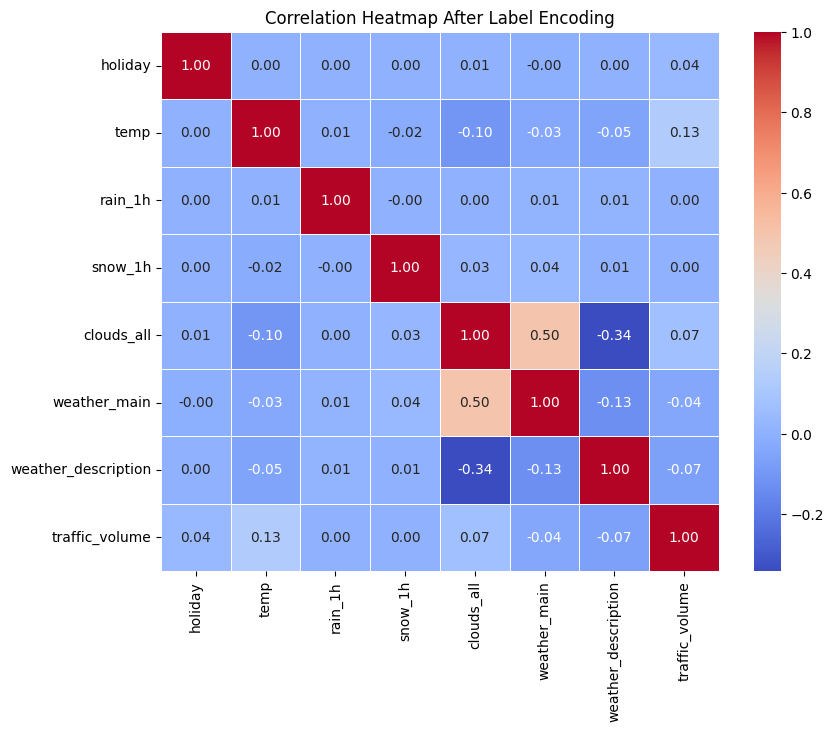

ADF Statistic: -28.019967663217848
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4304858126067175), '5%': np.float64(-2.8616000263321806), '10%': np.float64(-2.566801950040208)}

✅ Series is stationary


In [3]:

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

# Label Encoding
label_encoders = {}
categorical_cols = ['holiday', 'weather_main', 'weather_description']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle outliers using IQR
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume'] <= upper_bound)]


# Compute correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


# Create lag features

for lag in range(1, 4):  # 3 lag features for traffic volume
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)

# 🔹 Added lag features for holiday and weather_main
for lag in range(1, 4):
    df[f'holiday_lag{lag}'] = df['holiday'].shift(lag)
    df[f'weather_main_lag{lag}'] = df['weather_main'].shift(lag)

df.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
traffic_scaler = MinMaxScaler()
df['traffic_volume'] = traffic_scaler.fit_transform(df[['traffic_volume']])
# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Label Encoding")
plt.show()
# ADF test
adf_result = adfuller(df['traffic_volume'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("\n✅ Series is stationary")
else:
    print("\n❌ Series is NOT stationary")
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
X_train, y_train = train.drop(columns=['traffic_volume']), train['traffic_volume']
X_test, y_test = test.drop(columns=['traffic_volume']), test['traffic_volume']

# Convert to PyTorch tensors
X_train_torch, y_train_torch = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_torch, y_test_torch = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**LSTM Model Implementation and Training**</p>

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - loss: 0.0594 - val_loss: 0.0267
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - loss: 0.0343 - val_loss: 0.0265
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 0.0316 - val_loss: 0.0212
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 0.0235 - val_loss: 0.0079
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0140 - val_loss: 0.0068
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 0.0119 - val_loss: 0.0060
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 0.0102 - val_loss: 0.0056
Epoch 9/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 10/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 11/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 12/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 

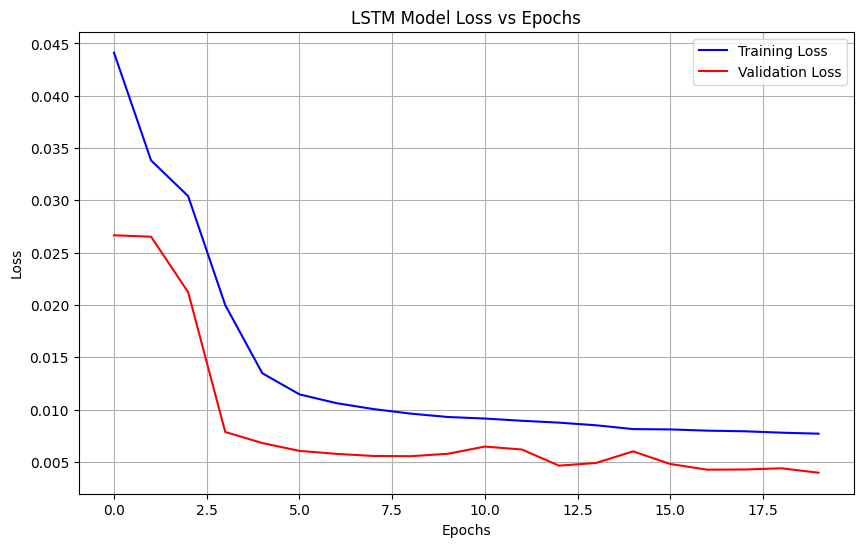

In [4]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = traffic_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Plot the training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**ARIMA Model Implementation and Training**</p>

In [5]:

#train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]
#model_arima = ARIMA(train_arima, order=(5, 1, 0))
#model_arima_fit = model_arima.fit()
#y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))
#y_pred_arima = y_pred_arima[:len(y_test_inv)]


train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]

# Grid Search for best (p, d, q)
best_aic = float("inf")
best_order = None
best_model_fit = None

# Define range for p, d, q
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_arima, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model_fit = model_fit
            except:
                continue

print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")

# Forecast using best model
y_pred_arima = best_model_fit.forecast(steps=len(test_arima)).to_numpy()
# Align length just in case
y_pred_arima = y_pred_arima[:len(test_arima)]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA Order: (3, 0, 3) with AIC: -68260.98528260602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**TSMixer Model Implementation and Training**</p>

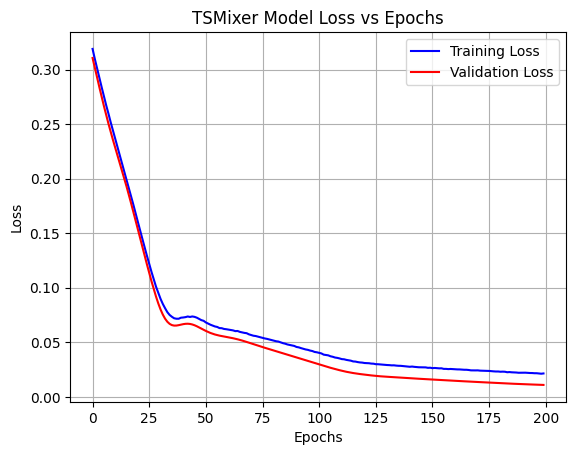

In [6]:
# TSMixer Model Definition
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Initialize the model
tsmixer_model = TSMixer(X_train_torch.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)

train_losses = []
val_losses = []

# Training loop with validation and loss tracking
for epoch in range(200):
    tsmixer_model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear the gradients
    outputs = tsmixer_model(X_train_torch).squeeze()  # Forward pass
    loss = criterion(outputs, y_train_torch)  # Compute training loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    # Track training loss
    train_losses.append(loss.item())

    # Validation loss
    tsmixer_model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for validation
        val_outputs = tsmixer_model(X_test_torch).squeeze()
        val_loss = criterion(val_outputs, y_test_torch)

    # Track validation loss
    val_losses.append(val_loss.item())

# Plotting the training and validation loss over epochs
plt.plot(range(200), train_losses, label='Training Loss', color='blue')
plt.plot(range(200), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TSMixer Model Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Making predictions with the trained TSMixer model
y_pred_tsmixer = tsmixer_model(X_test_torch).detach().numpy().flatten()
y_pred_tsmixer = traffic_scaler.inverse_transform(y_pred_tsmixer.reshape(-1, 1)).flatten()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid LSTM and TSMixer Model Implementation and Training**</p>

In [7]:
# ========================
# 1 DEFINE LSTM MODEL
# ========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(1))  # Add batch dimension
        x = self.fc(x[:, -1, :])
        return x

lstm_model = LSTMModel(X_train.shape[1])

Epoch [10/300], Loss: 0.0090
Epoch [20/300], Loss: 0.0079
Epoch [30/300], Loss: 0.0075
Epoch [40/300], Loss: 0.0072
Epoch [50/300], Loss: 0.0070
Epoch [60/300], Loss: 0.0068
Epoch [70/300], Loss: 0.0067
Epoch [80/300], Loss: 0.0066
Epoch [90/300], Loss: 0.0065
Epoch [100/300], Loss: 0.0064
Epoch [110/300], Loss: 0.0064
Epoch [120/300], Loss: 0.0063
Epoch [130/300], Loss: 0.0062
Epoch [140/300], Loss: 0.0062
Epoch [150/300], Loss: 0.0061
Epoch [160/300], Loss: 0.0061
Epoch [170/300], Loss: 0.0060
Epoch [180/300], Loss: 0.0060
Epoch [190/300], Loss: 0.0060
Epoch [200/300], Loss: 0.0060
Epoch [210/300], Loss: 0.0059
Epoch [220/300], Loss: 0.0059
Epoch [230/300], Loss: 0.0059
Epoch [240/300], Loss: 0.0059
Epoch [250/300], Loss: 0.0058
Epoch [260/300], Loss: 0.0058
Epoch [270/300], Loss: 0.0058
Epoch [280/300], Loss: 0.0058
Epoch [290/300], Loss: 0.0058
Epoch [300/300], Loss: 0.0058


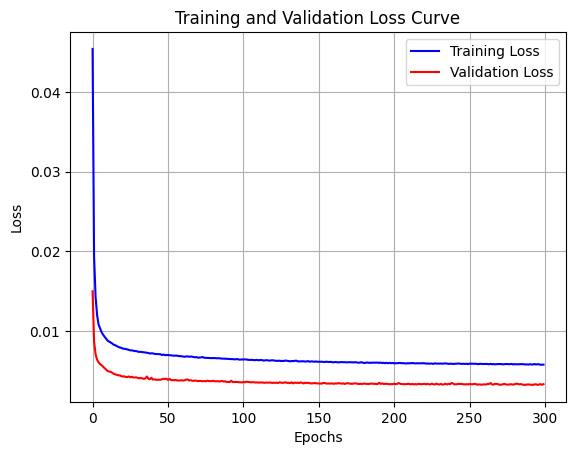

In [8]:
# ========================
# 2 DEFINE TSMixer MODEL
# ========================
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

tsmixer_model = TSMixer(X_train.shape[1])
# ========================
# 3 HYBRID MODEL (LSTM + TSMixer)
# ========================
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.lstm = LSTMModel(input_dim)
        self.tsmixer = TSMixer(input_dim)
        self.fc = nn.Linear(2, 1)  # Combine both outputs

    def forward(self, x):
        lstm_out = self.lstm(x)
        tsmixer_out = self.tsmixer(x)
        combined = torch.cat((lstm_out, tsmixer_out), dim=1)
        return self.fc(combined)

hybrid_model = HybridModel(X_train.shape[1])
# ========================
# 4 TRAINING
# ========================
criterion = nn.MSELoss()
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)

batch_size = 64
num_epochs = 300

train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    hybrid_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = hybrid_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))  # Store training loss

    # **Validation Loss Calculation (added)**
    hybrid_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_outputs = hybrid_model(X_test_torch).squeeze()  # Make predictions on test data
        val_loss = criterion(val_outputs, y_test_torch)
        val_losses.append(val_loss.item())  # Store validation loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# **Plotting the loss curves (added)**
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**hybrid KNN LSTM Implementation and Training**</p>

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0625 - val_loss: 0.0063
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0101 - val_loss: 0.0064
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0092 - val_loss: 0.0064
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0080 - val_loss: 0.0063
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0080 - val_loss: 0.0062


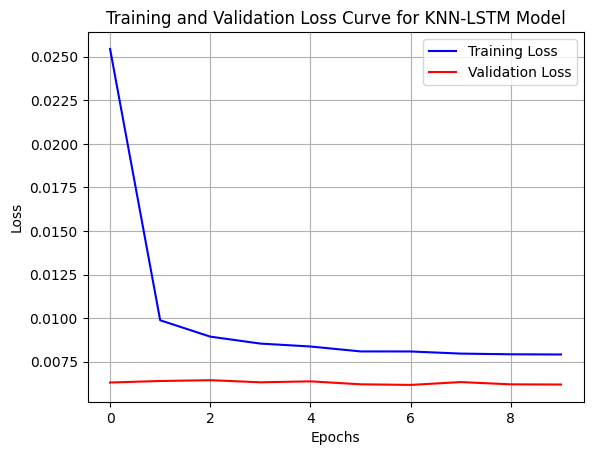

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [9]:
# ========================
#  KNN MODEL FOR FEATURE SELECTION
# ========================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
X_train_knn = knn.predict(X_train).reshape(-1, 1)
X_test_knn = knn.predict(X_test).reshape(-1, 1)

# ========================
#  KNN-LSTM MODEL
# ========================
def build_knn_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_knn_lstm = np.reshape(X_train_knn, (X_train_knn.shape[0], 1, 1))
X_test_knn_lstm = np.reshape(X_test_knn, (X_test_knn.shape[0], 1, 1))

knn_lstm_model = build_knn_lstm_model((1, 1))

# **Updated Part: Added validation and loss curve tracking**
history = knn_lstm_model.fit(X_train_knn_lstm, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test_knn_lstm, y_test))

# **Plotting the training and validation loss curves (added)**
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for KNN-LSTM Model')
plt.legend()
plt.grid(True)
plt.show()

y_pred_knn_lstm = knn_lstm_model.predict(X_test_knn_lstm)

# Rescale predictions back to original scale
y_pred_knn_lstm = traffic_scaler.inverse_transform(y_pred_knn_lstm)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet Model Implementation and Training**</p>

Epoch 1/20, Train Loss: 0.0191, Val Loss: 0.0058
Epoch 2/20, Train Loss: 0.0087, Val Loss: 0.0057
Epoch 3/20, Train Loss: 0.0081, Val Loss: 0.0050
Epoch 4/20, Train Loss: 0.0079, Val Loss: 0.0063
Epoch 5/20, Train Loss: 0.0076, Val Loss: 0.0047
Epoch 6/20, Train Loss: 0.0074, Val Loss: 0.0047
Epoch 7/20, Train Loss: 0.0072, Val Loss: 0.0045
Epoch 8/20, Train Loss: 0.0070, Val Loss: 0.0044
Epoch 9/20, Train Loss: 0.0070, Val Loss: 0.0044
Epoch 10/20, Train Loss: 0.0068, Val Loss: 0.0042
Epoch 11/20, Train Loss: 0.0068, Val Loss: 0.0041
Epoch 12/20, Train Loss: 0.0068, Val Loss: 0.0044
Epoch 13/20, Train Loss: 0.0067, Val Loss: 0.0043
Epoch 14/20, Train Loss: 0.0068, Val Loss: 0.0041
Epoch 15/20, Train Loss: 0.0068, Val Loss: 0.0041
Epoch 16/20, Train Loss: 0.0067, Val Loss: 0.0043
Epoch 17/20, Train Loss: 0.0066, Val Loss: 0.0039
Epoch 18/20, Train Loss: 0.0066, Val Loss: 0.0041
Epoch 19/20, Train Loss: 0.0067, Val Loss: 0.0040
Epoch 20/20, Train Loss: 0.0067, Val Loss: 0.0039


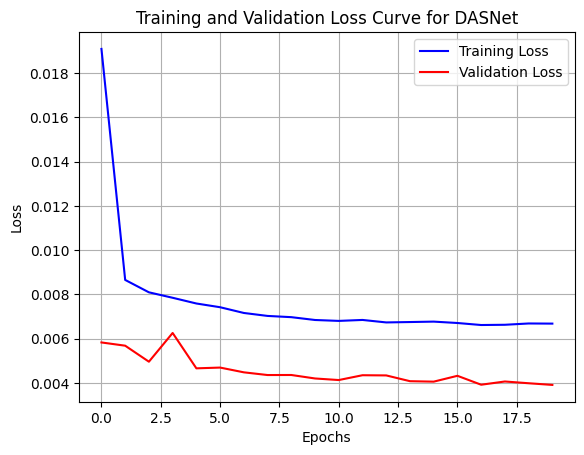

In [10]:
# ========================
#  DUAL SELF-ATTENTION NETWORK (DASNet)
# ========================
class DASNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, num_heads=4):
        super(DASNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Temporal Self-Attention
        self.temporal_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        # Feature Self-Attention (custom linear attention over features)
        self.feature_attn = nn.Linear(hidden_dim, 1)

        # Fusion
        self.fc_fusion = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)

        # --- Temporal attention ---
        temp_attn_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out)
        temp_context = torch.mean(temp_attn_out, dim=1)  # (batch, hidden_dim)

        # --- Feature attention (soft attention across hidden_dim) ---
        feat_weights = torch.softmax(self.feature_attn(lstm_out), dim=1)  # (batch, seq_len, 1)
        feat_context = torch.sum(feat_weights * lstm_out, dim=1)  # (batch, hidden_dim)

        # --- Fusion ---
        fusion = torch.cat([temp_context, feat_context], dim=1)  # (batch, hidden_dim*2)
        fusion = torch.relu(self.fc_fusion(fusion))  # (batch, hidden_dim)

        out = self.fc_out(fusion)  # (batch, 1)
        return out.squeeze()


# ========================
#  MODEL SETUP
# ========================
input_dim = X_train_torch.shape[1]
dasnet = DASNet(input_dim=input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(dasnet.parameters(), lr=0.001)

# Keep seq_len=1 for LSTM input
train_dataset = TensorDataset(X_train_torch.unsqueeze(1), y_train_torch)
test_dataset = TensorDataset(X_test_torch.unsqueeze(1), y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ========================
#  TRAINING LOOP
# ========================
train_losses, val_losses = [], []
epochs = 20

for epoch in range(epochs):
    dasnet.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = dasnet(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    dasnet.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = dasnet(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


# ========================
#  LOSS CURVES
# ========================
plt.plot(range(epochs), train_losses, label="Training Loss", color="blue")
plt.plot(range(epochs), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve for DASNet")
plt.legend()
plt.grid(True)
plt.show()


# ========================
#  EVALUATION (PREDICTIONS ONLY)
# ========================
dasnet.eval()
y_pred_list, y_true_list = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = dasnet(X_batch)
        y_pred_list.append(y_pred.numpy())
        y_true_list.append(y_batch.numpy())

y_pred_list = np.concatenate(y_pred_list)
y_true_list = np.concatenate(y_true_list)

# Convert back to original scale
y_pred_actual_Dasnet = traffic_scaler.inverse_transform(y_pred_list.reshape(-1, 1))
y_true_actual = traffic_scaler.inverse_transform(y_true_list.reshape(-1, 1))



#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet LSTM Model Implementation and Training**</p>

In [ ]:
# Define GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T  # Fix dimension mismatch
        return torch.relu(self.fc(x))

# Define DASNet-LSTM Model
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super(DASNetLSTM, self).__init__()
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = x * attn_weights  # Apply attention
        x = x.unsqueeze(1)  # LSTM expects (batch, seq_len, features)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])  # Final output

# Adjacency matrix (Identity as placeholder)
adj_matrix = np.eye(X_train.shape[1])


In [ ]:
model = DASNetLSTM(input_dim=X_train.shape[1], hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Training loop
num_epochs = 600

# Convert X_train to a PyTorch tensor before feeding it into the model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Also convert y_train for consistency

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze() # Pass the tensor here
    loss = criterion(outputs, y_train_tensor) # Pass the tensor here
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/600], Loss: 0.2025
Epoch [20/600], Loss: 0.1757
Epoch [30/600], Loss: 0.1504
Epoch [40/600], Loss: 0.1255
Epoch [50/600], Loss: 0.1007
Epoch [60/600], Loss: 0.0796
Epoch [70/600], Loss: 0.0678
Epoch [80/600], Loss: 0.0643
Epoch [90/600], Loss: 0.0624
Epoch [100/600], Loss: 0.0587
Epoch [110/600], Loss: 0.0536
Epoch [120/600], Loss: 0.0469
Epoch [130/600], Loss: 0.0401
Epoch [140/600], Loss: 0.0347
Epoch [150/600], Loss: 0.0310
Epoch [160/600], Loss: 0.0285
Epoch [170/600], Loss: 0.0263
Epoch [180/600], Loss: 0.0242
Epoch [190/600], Loss: 0.0219
Epoch [200/600], Loss: 0.0196
Epoch [210/600], Loss: 0.0172
Epoch [220/600], Loss: 0.0150
Epoch [230/600], Loss: 0.0132
Epoch [240/600], Loss: 0.0119
Epoch [250/600], Loss: 0.0112
Epoch [260/600], Loss: 0.0109
Epoch [270/600], Loss: 0.0106
Epoch [280/600], Loss: 0.0104
Epoch [290/600], Loss: 0.0103
Epoch [300/600], Loss: 0.0102
Epoch [310/600], Loss: 0.0101
Epoch [320/600], Loss: 0.0100
Epoch [330/600], Loss: 0.0099
Epoch [340/600], Lo

In [ ]:
# Evaluate model
model.eval()
# Convert X_test to a PyTorch tensor before feeding it into the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32) # Convert X_test to Tensor
y_pred_Dasnet_LSTM = model(X_test_tensor).detach().numpy() # Pass the tensor to the model


Epoch [10/300] | Train Loss: 0.3691 | Val Loss: 0.3623
Epoch [20/300] | Train Loss: 0.3274 | Val Loss: 0.3206
Epoch [30/300] | Train Loss: 0.2851 | Val Loss: 0.2781
Epoch [40/300] | Train Loss: 0.2388 | Val Loss: 0.2312
Epoch [50/300] | Train Loss: 0.1863 | Val Loss: 0.1780
Epoch [60/300] | Train Loss: 0.1330 | Val Loss: 0.1251
Epoch [70/300] | Train Loss: 0.0894 | Val Loss: 0.0832
Epoch [80/300] | Train Loss: 0.0667 | Val Loss: 0.0636
Epoch [90/300] | Train Loss: 0.0647 | Val Loss: 0.0625
Epoch [100/300] | Train Loss: 0.0608 | Val Loss: 0.0580
Epoch [110/300] | Train Loss: 0.0577 | Val Loss: 0.0547
Epoch [120/300] | Train Loss: 0.0547 | Val Loss: 0.0516
Epoch [130/300] | Train Loss: 0.0518 | Val Loss: 0.0485
Epoch [140/300] | Train Loss: 0.0487 | Val Loss: 0.0453
Epoch [150/300] | Train Loss: 0.0457 | Val Loss: 0.0421
Epoch [160/300] | Train Loss: 0.0427 | Val Loss: 0.0390
Epoch [170/300] | Train Loss: 0.0395 | Val Loss: 0.0358
Epoch [180/300] | Train Loss: 0.0359 | Val Loss: 0.0320
E

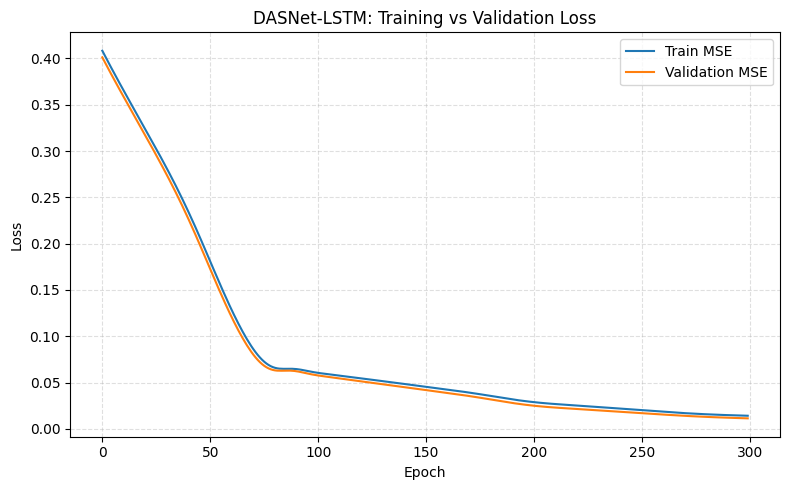

In [11]:

# -------------------------
# GCN layer
# -------------------------
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        # x: [batch, feat], adj: [feat, feat]
        x = torch.matmul(adj, x.T).T
        return torch.relu(self.fc(x))

# -------------------------
# DASNet-LSTM
# -------------------------
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super().__init__()
        # register adj so it follows .to(device)
        self.register_buffer("adj", torch.tensor(adj_matrix, dtype=torch.float32))
        self.gcn  = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc   = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)                 # [batch, hidden_dim]
        attn_weights = torch.softmax(self.attn(x), dim=1)  # [batch, hidden_dim]
        x = x * attn_weights
        x = x.unsqueeze(1)                         # [batch, 1, hidden_dim]
        x, _ = self.lstm(x)                        # [batch, 1, lstm_units]
        out = self.fc(x[:, -1, :])                 # [batch, 1]
        return out.squeeze(-1)                     # [batch]

# -------------------------
# Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim   = X_train.shape[1]
adj_matrix  = np.eye(input_dim)

model = DASNetLSTM(input_dim=input_dim, hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Tensors + shapes
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values,  dtype=torch.float32).view(-1).to(device)
X_test_tensor  = torch.tensor(X_test.values,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test.values,   dtype=torch.float32).view(-1).to(device)

# -------------------------
# Train (with validation)
# -------------------------
num_epochs = 300
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    train_losses.append(float(loss.item()))
    val_losses.append(float(val_loss.item()))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# -------------------------
# Evaluate
# -------------------------
model.eval()
with torch.no_grad():
    y_pred_Dasnet_LSTM = model(X_test_tensor).detach().cpu().numpy()
    y_true             = y_test_tensor.detach().cpu().numpy()

# (Optional) inverse-scale outside if you need:
# y_pred_actual = traffic_scaler.inverse_transform(y_pred_Dasnet_LSTM.reshape(-1, 1)).flatten()
# y_true_actual = traffic_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# -------------------------
# Plot Train vs Validation Loss
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DASNet-LSTM: Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing Graph Convulation Network**</p>

Epoch [10/300] | Train Loss: 0.2731 | Val Loss: 0.2436
Epoch [20/300] | Train Loss: 0.1005 | Val Loss: 0.0868
Epoch [30/300] | Train Loss: 0.0577 | Val Loss: 0.0566
Epoch [40/300] | Train Loss: 0.0591 | Val Loss: 0.0573
Epoch [50/300] | Train Loss: 0.0477 | Val Loss: 0.0447
Epoch [60/300] | Train Loss: 0.0417 | Val Loss: 0.0382
Epoch [70/300] | Train Loss: 0.0367 | Val Loss: 0.0331
Epoch [80/300] | Train Loss: 0.0332 | Val Loss: 0.0294
Epoch [90/300] | Train Loss: 0.0300 | Val Loss: 0.0262
Epoch [100/300] | Train Loss: 0.0277 | Val Loss: 0.0239
Epoch [110/300] | Train Loss: 0.0259 | Val Loss: 0.0220
Epoch [120/300] | Train Loss: 0.0245 | Val Loss: 0.0206
Epoch [130/300] | Train Loss: 0.0232 | Val Loss: 0.0193
Epoch [140/300] | Train Loss: 0.0218 | Val Loss: 0.0181
Epoch [150/300] | Train Loss: 0.0204 | Val Loss: 0.0167
Epoch [160/300] | Train Loss: 0.0189 | Val Loss: 0.0154
Epoch [170/300] | Train Loss: 0.0174 | Val Loss: 0.0140
Epoch [180/300] | Train Loss: 0.0160 | Val Loss: 0.0128
E

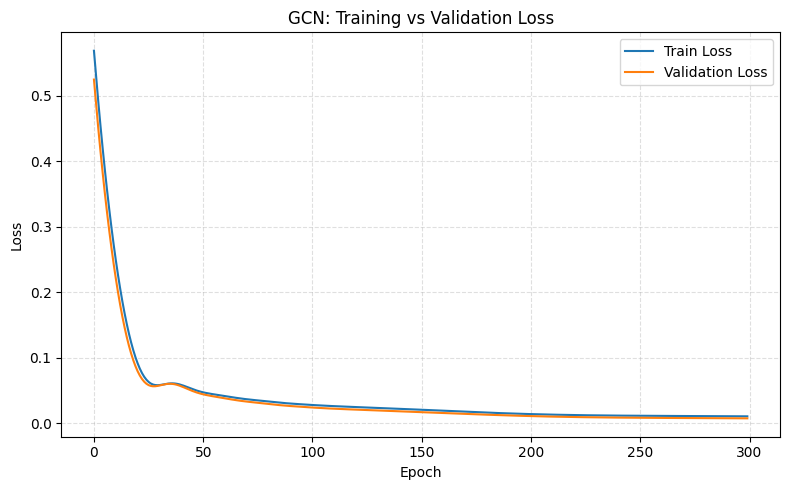

In [12]:
# Create a simple GCN layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T
        return torch.relu(self.fc(x))

# Define GCN model
class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix):
        super().__init__()
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        x = self.fc(x)
        return x

# Create adjacency matrix (for simplicity, using identity matrix)
# In real applications, you'll have an actual graph structure to define adj matrix
adj_matrix = np.eye(X_train.shape[1])

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGCN(input_dim, hidden_dim, output_dim, adj_matrix).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Convert data to PyTorch tensors
X_train_torch, y_train_torch = torch.tensor(X_train.values, dtype=torch.float32).to(device), torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_torch, y_test_torch = torch.tensor(X_test.values, dtype=torch.float32).to(device), torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Training loop
num_epochs = 300
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs.squeeze(-1), y_train_torch)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_torch)
        val_loss = criterion(val_outputs.squeeze(-1), y_test_torch)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Evaluate model on test set
model.eval()
with torch.no_grad():
    y_pred_GCN = model(X_test_torch).detach().cpu().numpy()

# -------------------------
# Plot Train vs Validation Loss
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN: Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing TimeMixer Model**</p>

Epoch [10/250] | Train Loss: 0.0742 | Test Loss: 0.0429
Epoch [20/250] | Train Loss: 0.0468 | Test Loss: 0.0292
Epoch [30/250] | Train Loss: 0.0357 | Test Loss: 0.0215
Epoch [40/250] | Train Loss: 0.0295 | Test Loss: 0.0173
Epoch [50/250] | Train Loss: 0.0259 | Test Loss: 0.0147
Epoch [60/250] | Train Loss: 0.0236 | Test Loss: 0.0126
Epoch [70/250] | Train Loss: 0.0214 | Test Loss: 0.0110
Epoch [80/250] | Train Loss: 0.0199 | Test Loss: 0.0097
Epoch [90/250] | Train Loss: 0.0189 | Test Loss: 0.0088
Epoch [100/250] | Train Loss: 0.0178 | Test Loss: 0.0083
Epoch [110/250] | Train Loss: 0.0170 | Test Loss: 0.0079
Epoch [120/250] | Train Loss: 0.0162 | Test Loss: 0.0077
Epoch [130/250] | Train Loss: 0.0157 | Test Loss: 0.0075
Epoch [140/250] | Train Loss: 0.0153 | Test Loss: 0.0073
Epoch [150/250] | Train Loss: 0.0146 | Test Loss: 0.0071
Epoch [160/250] | Train Loss: 0.0144 | Test Loss: 0.0069
Epoch [170/250] | Train Loss: 0.0140 | Test Loss: 0.0068
Epoch [180/250] | Train Loss: 0.0137 | T

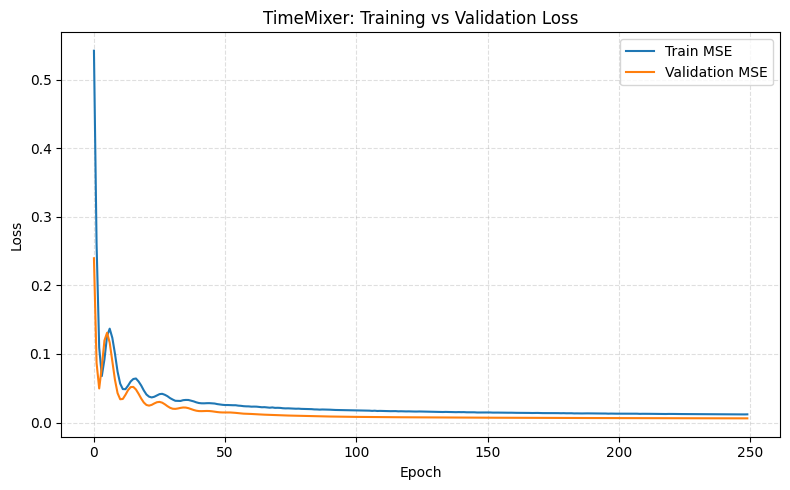

In [13]:
# --- TimeMixer model ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

class TimeMixer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=3):
        super(TimeMixer, self).__init__()
        self.mixer_blocks = nn.Sequential(
            *[TimeMixerBlock(input_dim, hidden_dim) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.mixer_blocks(x)          # [batch, input_dim]
        x = self.output_layer(x)          # [batch, 1]
        return x.squeeze(-1)              # [batch]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss, optimizer
input_dim = X_train.shape[1]
model = TimeMixer(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device (+ ensure shapes)
X_train_torch = X_train_torch.to(device)
X_test_torch  = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device).view(-1)  # ensure 1-D
y_test_torch  = y_test_torch.to(device).view(-1)   # ensure 1-D

# If inputs are 3D from earlier LSTM code, squeeze seq_len dimension -> [batch, input_dim]
if X_train_torch.dim() == 3 and X_train_torch.size(1) == 1:
    X_train_torch = X_train_torch.squeeze(1)
if X_test_torch.dim() == 3 and X_test_torch.size(1) == 1:
    X_test_torch = X_test_torch.squeeze(1)

# --- Track losses ---
train_losses, val_losses = [], []

# Training loop
epochs = 250
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_torch)
        val_loss = criterion(val_outputs, y_test_torch)

    train_losses.append(float(loss.item()))
    val_losses.append(float(val_loss.item()))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).detach().cpu().numpy()
    y_true = y_test_torch.detach().cpu().numpy()

# --- Plot Train vs Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TimeMixer: Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid TimeMixer-LSTM**</p>

Epoch [10/100] | Train Loss: 0.0793 | Test Loss: 0.0602
Epoch [20/100] | Train Loss: 0.0424 | Test Loss: 0.0300
Epoch [30/100] | Train Loss: 0.0304 | Test Loss: 0.0182
Epoch [40/100] | Train Loss: 0.0234 | Test Loss: 0.0148
Epoch [50/100] | Train Loss: 0.0196 | Test Loss: 0.0118
Epoch [60/100] | Train Loss: 0.0165 | Test Loss: 0.0089
Epoch [70/100] | Train Loss: 0.0144 | Test Loss: 0.0073
Epoch [80/100] | Train Loss: 0.0131 | Test Loss: 0.0067
Epoch [90/100] | Train Loss: 0.0122 | Test Loss: 0.0063
Epoch [100/100] | Train Loss: 0.0117 | Test Loss: 0.0061


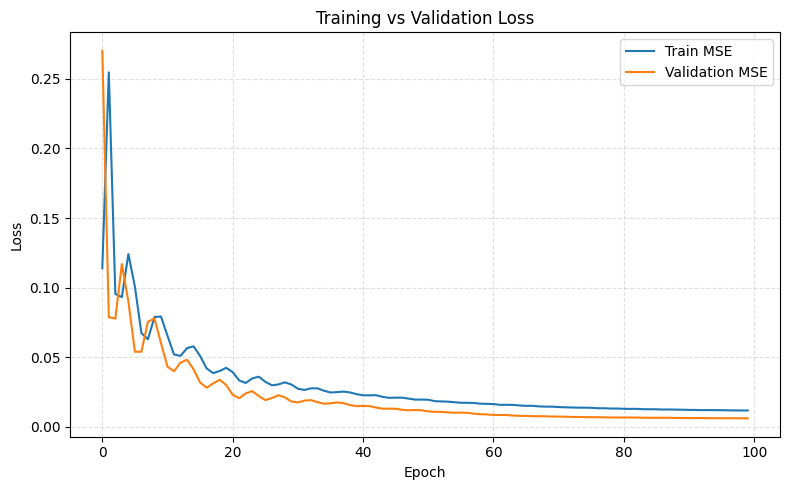

In [14]:
# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test.values,  dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1)  # ensure 1-D
y_test_torch  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1)  # ensure 1-D

# Ensure input is 3D for LSTM: [batch, seq_len=1, input_dim]
if X_train_torch.dim() == 2:
    X_train_torch = X_train_torch.unsqueeze(1)
if X_test_torch.dim() == 2:
    X_test_torch = X_test_torch.unsqueeze(1)

# --- TimeMixer Block ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

# --- Hybrid LSTM + TimeMixer Model ---
class HybridLSTMTimeMixer(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, tm_hidden=64, num_tm_blocks=2):
        super(HybridLSTMTimeMixer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.tm_blocks = nn.Sequential(
            *[TimeMixerBlock(lstm_hidden, tm_hidden) for _ in range(num_tm_blocks)]
        )
        self.output_layer = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)       # [batch, seq_len=1, lstm_hidden]
        x = lstm_out.squeeze(1)          # [batch, lstm_hidden]
        x = self.tm_blocks(x)            # TimeMixer blocks
        out = self.output_layer(x)       # [batch, 1]
        return out.squeeze(-1)           # [batch]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
input_dim = X_train.shape[1]
model = HybridLSTMTimeMixer(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_torch = X_train_torch.to(device)
X_test_torch  = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device)
y_test_torch  = y_test_torch.to(device)

# --- NEW: Track losses ---
train_losses = []
val_losses = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    # --- NEW: validation every epoch & store losses ---
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_torch)
        val_loss = criterion(val_outputs, y_test_torch)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).detach().cpu().numpy()
    y_true = y_test_torch.detach().cpu().numpy()

# Inverse transform to original scale
y_pred_TimeMixer_LSTM = traffic_scaler.inverse_transform(y_pred_TimeMixer.reshape(-1, 1)).flatten()
y_true_actual = traffic_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# --- NEW: Plot Train vs Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Evaluations metrics**</p>

In [15]:
# ========================
# 6⃣ MODEL EVALUATION
# ========================
hybrid_model.eval()
with torch.no_grad():
    # Reshape X_test_torch to 3D for LSTM
    y_test_pred = hybrid_model(X_test_torch.squeeze(1)).squeeze().numpy()  # Remove extra dimension

# Inverse transform predictions
y_test_pred_inv = traffic_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_actual_inv = traffic_scaler.inverse_transform(y_test_torch.numpy().reshape(-1, 1)).flatten()
# Metrics calculation
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(mse, 5), round(rmse, 5), round(mae, 5), round(mape, 5), round(r2, 5)

# Evaluate models
metrics_hybrid = evaluate_model(y_test_actual_inv, y_test_pred_inv)
metrics_lstm = evaluate_model(y_test_actual_inv, y_pred_lstm)
metrics_arima = evaluate_model(y_test_actual_inv, y_pred_arima)
metrics_tsmixer = evaluate_model(y_test_actual_inv, y_pred_tsmixer)
metrics_knn_lstm = evaluate_model(y_test_actual_inv, y_pred_knn_lstm)
metrics_CGN = evaluate_model(y_test_actual_inv,y_pred_GCN)
metrics_dasnet = evaluate_model(y_test_actual_inv, y_pred_actual_Dasnet)
metrics_dasnet_lstm=evaluate_model(y_test_actual_inv,y_pred_Dasnet_LSTM)
metrics_TimeMixer=evaluate_model(y_test_actual_inv,y_pred_TimeMixer)
metrics_TimeMixer_LSTM=evaluate_model(y_test_actual_inv,y_pred_TimeMixer_LSTM)

# PrettyTable for Model Comparison
table = PrettyTable()
table.field_names = ["Model", "MSE", "RMSE", "MAE", "MAPE", "R²"]
table.add_row(["LSTM", *metrics_lstm])
table.add_row(["ARIMA", *metrics_arima])
table.add_row(["TSMixer", *metrics_tsmixer])
table.add_row(["Hybrid LSTM-TSMixer", *metrics_hybrid])
table.add_row(["Hybrid KNN-LSTM", *metrics_knn_lstm])
table.add_row(["Graph Convolution Network", *metrics_CGN])
table.add_row(["DasNet",*metrics_dasnet])
table.add_row(["Hybrid DasNet LSTM",*metrics_dasnet_lstm])
table.add_row(["TimeMixer",*metrics_TimeMixer])
table.add_row(["Hybrid TimeMixer-LSTM",*metrics_TimeMixer_LSTM])

print(table)


+---------------------------+---------+---------+---------+-----------+---------+
|           Model           |   MSE   |   RMSE  |   MAE   |    MAPE   |    R²   |
+---------------------------+---------+---------+---------+-----------+---------+
|            LSTM           | 0.00396 | 0.06292 | 0.04345 |  16.28731 | 0.94582 |
|           ARIMA           | 0.07302 | 0.27022 | 0.23653 | 171.01306 | 0.00044 |
|          TSMixer          | 0.01091 | 0.10446 | 0.07621 |  35.99764 | 0.85062 |
|    Hybrid LSTM-TSMixer    | 0.00331 | 0.05755 | 0.03826 |  14.28339 | 0.95467 |
|      Hybrid KNN-LSTM      |  0.0062 | 0.07872 | 0.05428 | 184.69833 | 0.91517 |
| Graph Convolution Network | 0.00714 | 0.08448 | 0.06221 | 185.53578 |  0.9023 |
|           DasNet          | 0.00391 | 0.06254 | 0.04371 | 187.29918 | 0.94645 |
|     Hybrid DasNet LSTM    | 0.01133 | 0.10646 | 0.08462 |  60.2753  | 0.84487 |
|         TimeMixer         | 0.00606 | 0.07783 | 0.05583 |  21.19308 | 0.91709 |
|   Hybrid TimeM

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Plotting**</p>

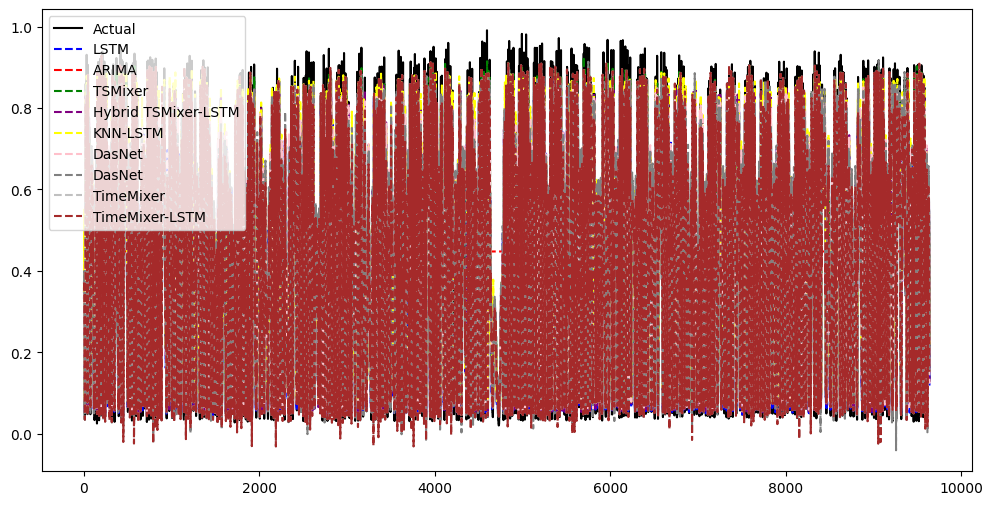

In [ ]:
# ========================
# 6️⃣ PLOT MODEL PREDICTIONS
# ========================
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_inv, label="Actual", color='black')
plt.plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
plt.plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
plt.plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
plt.plot( y_test_pred, label="Hybrid TSMixer-LSTM", linestyle='dashed', color='purple')
plt.plot(y_pred_knn_lstm, label="KNN-LSTM", linestyle='dashed', color='yellow')
plt.plot(y_pred_actual_Dasnet, label="DasNet", linestyle='dashed', color='pink')
plt.plot(y_pred_Dasnet_LSTM, label="DasNet", linestyle='dashed', color='grey')
plt.plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dashed', color='silver')
plt.plot(y_pred_TimeMixer_LSTM, label="TimeMixer-LSTM", linestyle='dashed', color='brown')
plt.legend()
plt.show()



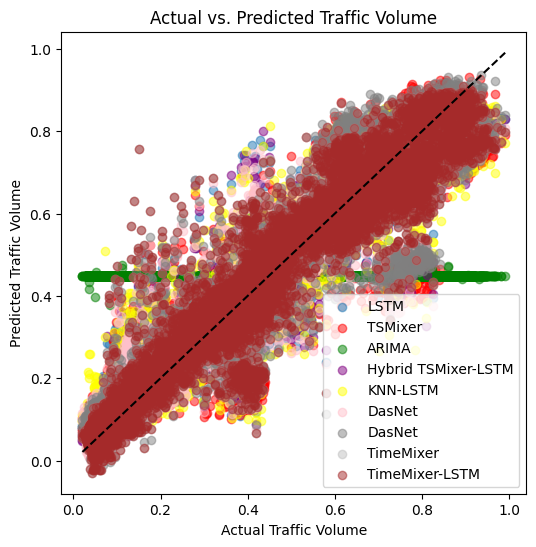

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.scatter(y_test, y_pred_arima, alpha=0.5, label="ARIMA", color='green')
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.scatter(y_test, y_pred_Dasnet_LSTM, alpha=0.5, label="DasNet", color='grey')
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer-LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


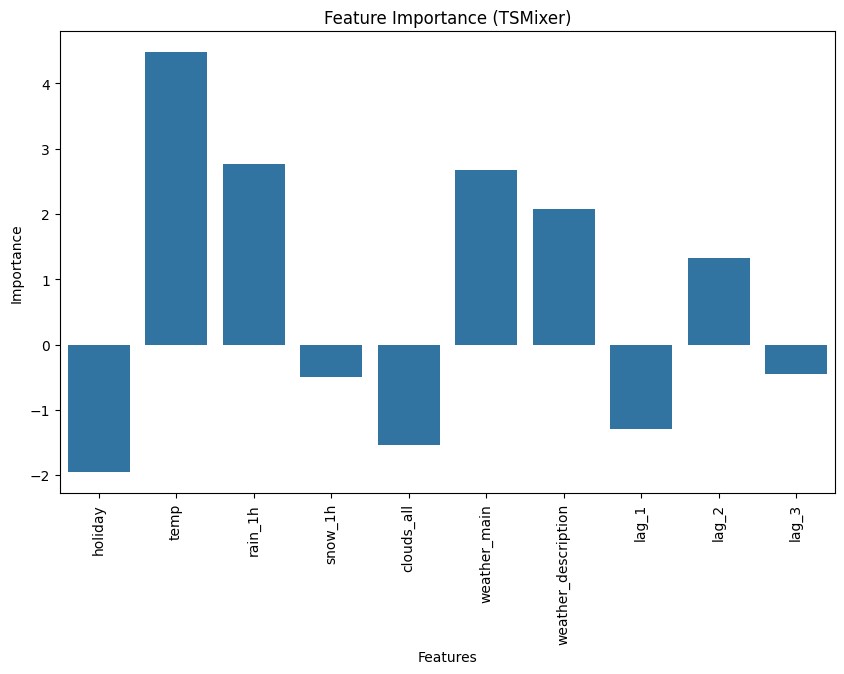

In [ ]:
import seaborn as sns
importance = tsmixer_model.fc1.weight.detach().numpy().sum(axis=0)  # Example for TSMixer
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=importance)
plt.xticks(rotation=90)
plt.title("Feature Importance (TSMixer)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

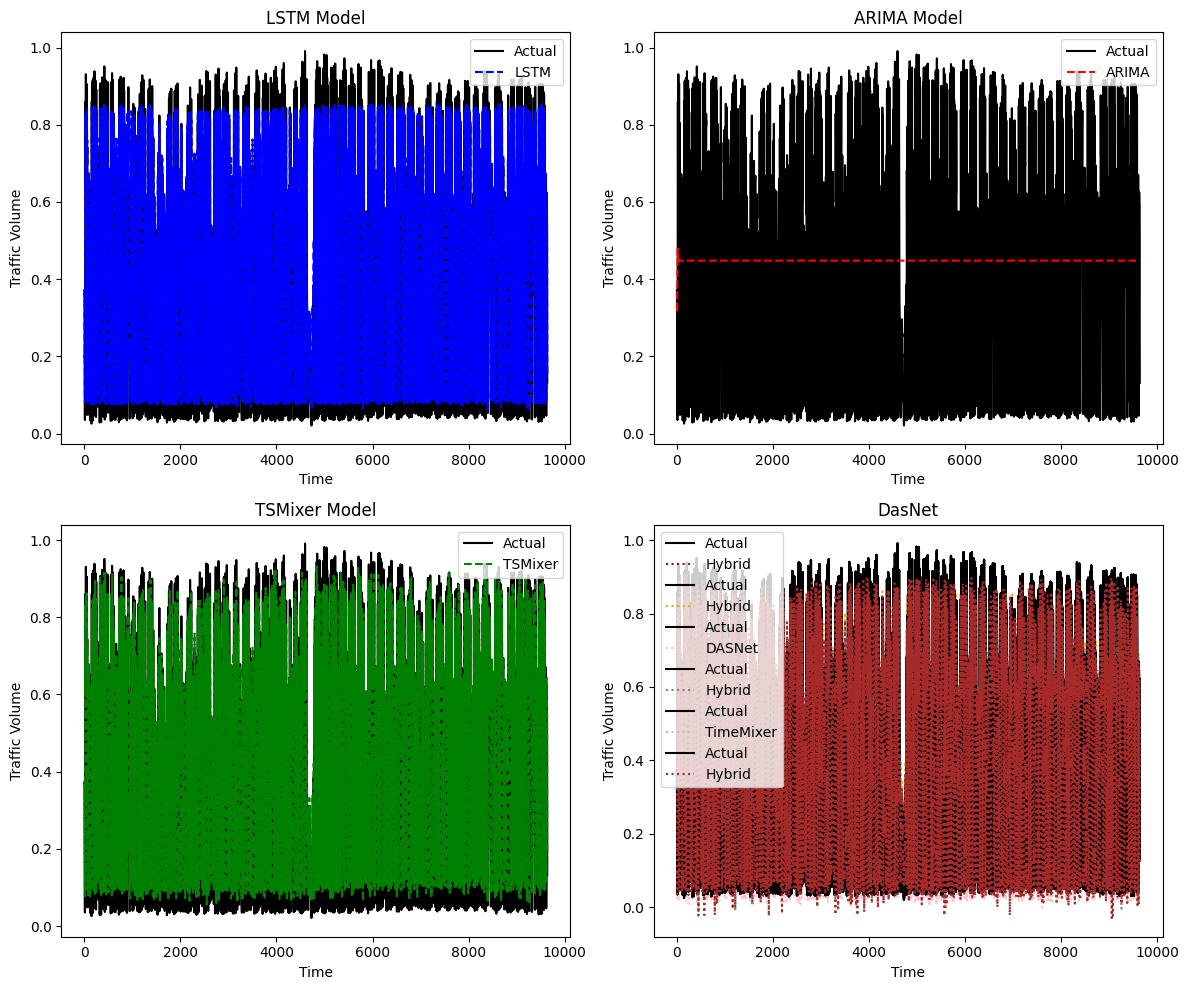

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(y_test_actual_inv, label="Actual", color='black')
axes[0, 0].plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
axes[0, 0].set_title("LSTM Model")

axes[0, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[0, 1].plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
axes[0, 1].set_title("ARIMA Model")

axes[1, 0].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 0].plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
axes[1, 0].set_title("TSMixer Model")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_test_pred, label="Hybrid", linestyle='dotted', color='purple')
axes[1, 1].set_title("Hybrid TSMixer-LSTM")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_knn_lstm, label="Hybrid", linestyle='dotted', color='orange')
axes[1, 1].set_title("KNN LTM")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_actual_Dasnet, label="DASNet", linestyle='dotted', color='pink')
axes[1, 1].set_title("DasNet")


axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_Dasnet_LSTM, label="Hybrid", linestyle='dotted', color='grey')
axes[1, 1].set_title("DasNet")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dotted', color='silver')
axes[1, 1].set_title("TimeMixer")
axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer_LSTM, label="Hybrid", linestyle='dotted', color='brown')
axes[1, 1].set_title("DasNet")




for ax in axes.flat:
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Traffic Volume")

plt.tight_layout()
plt.show()


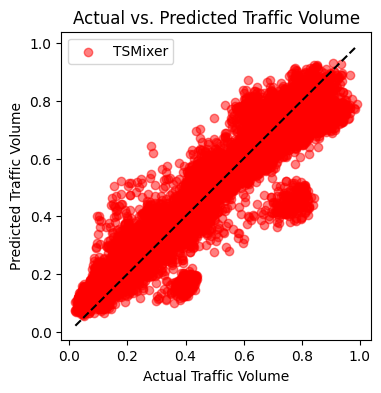

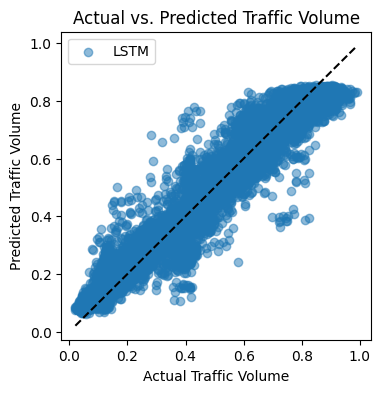

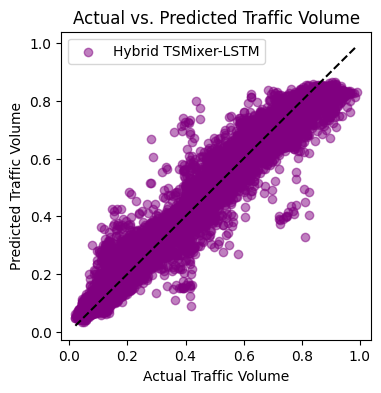

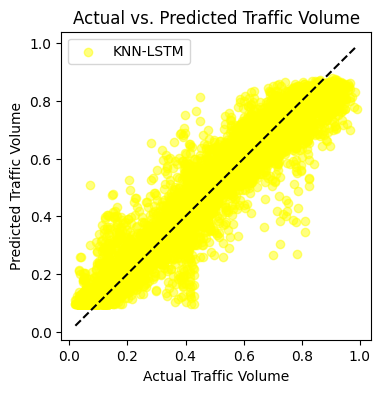

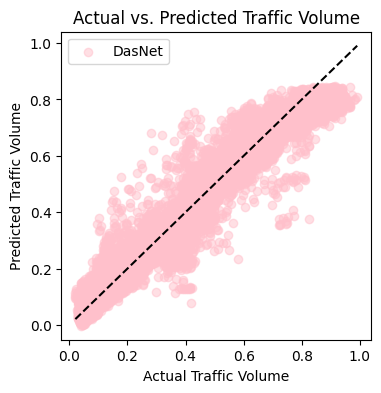

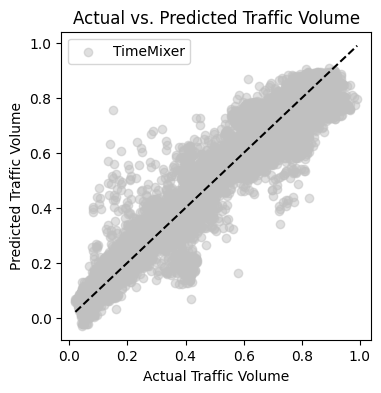

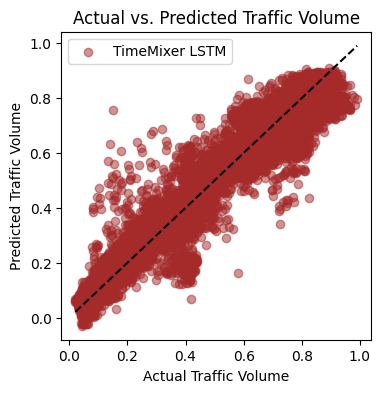

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

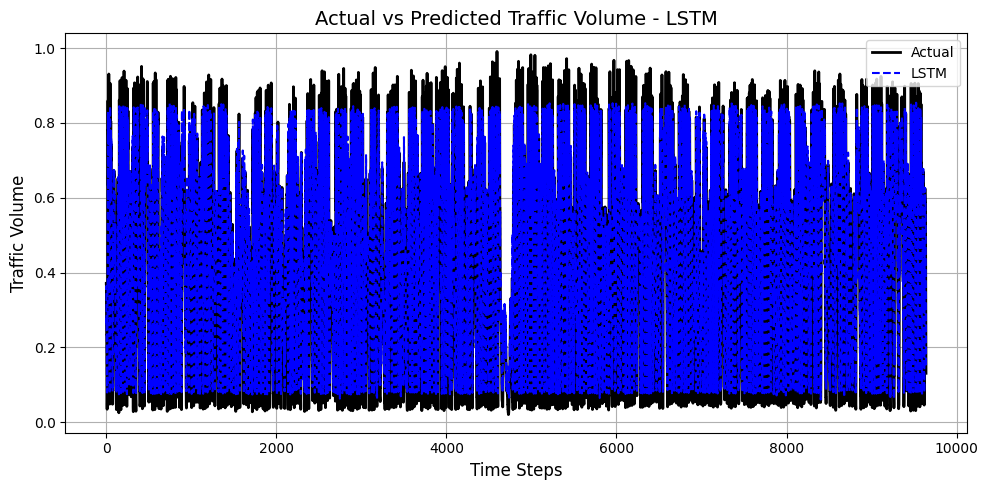

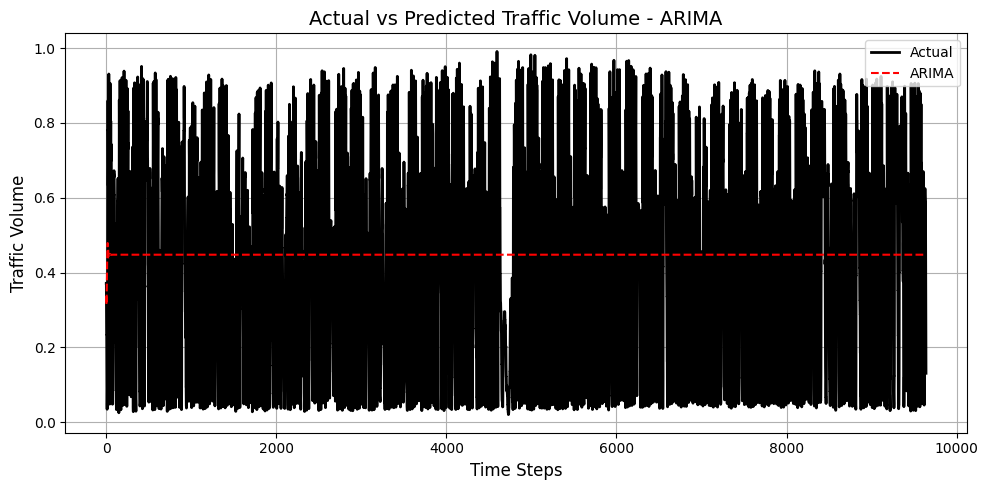

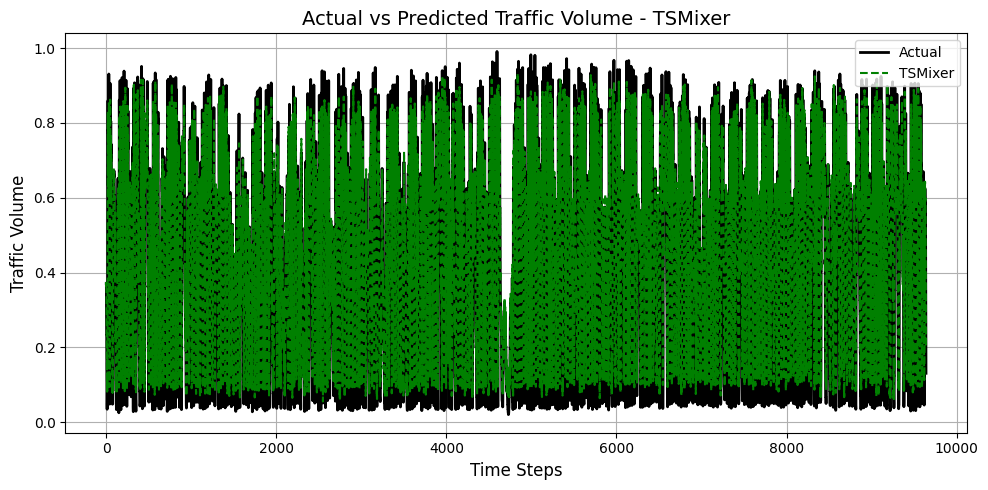

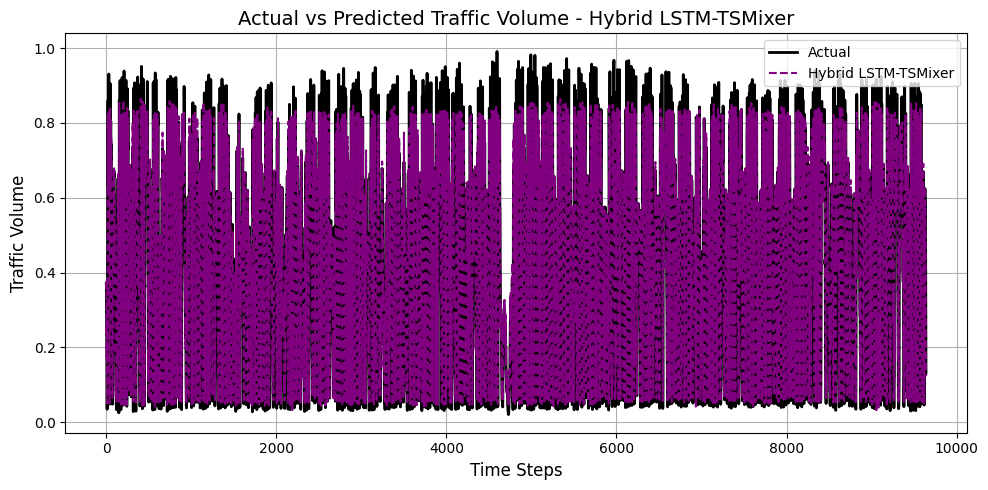

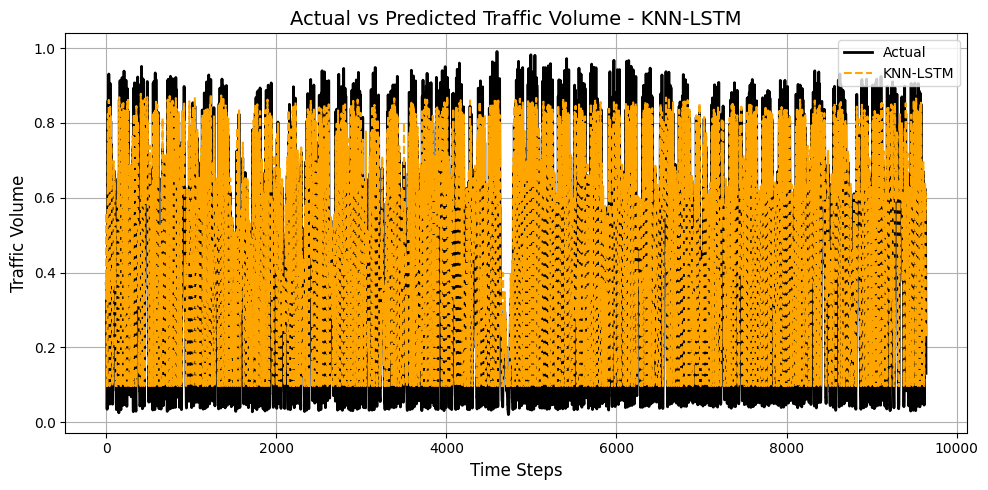

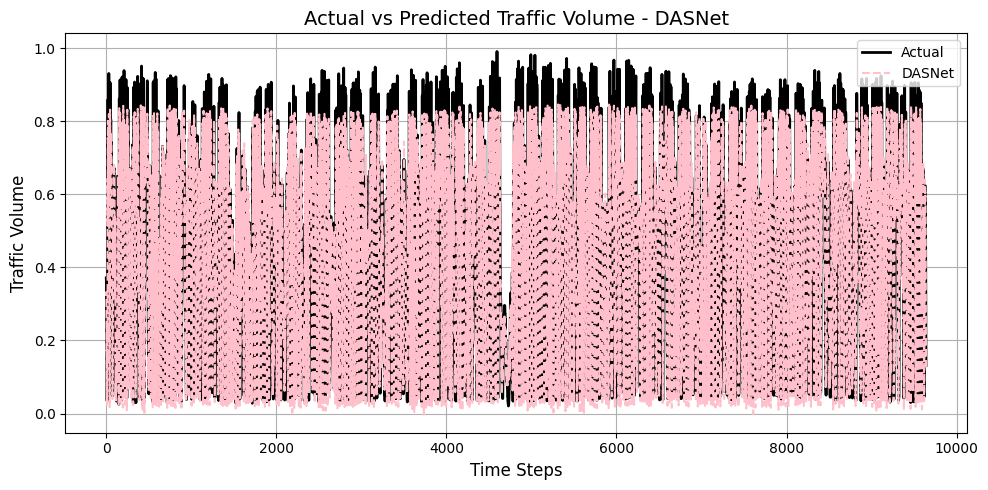

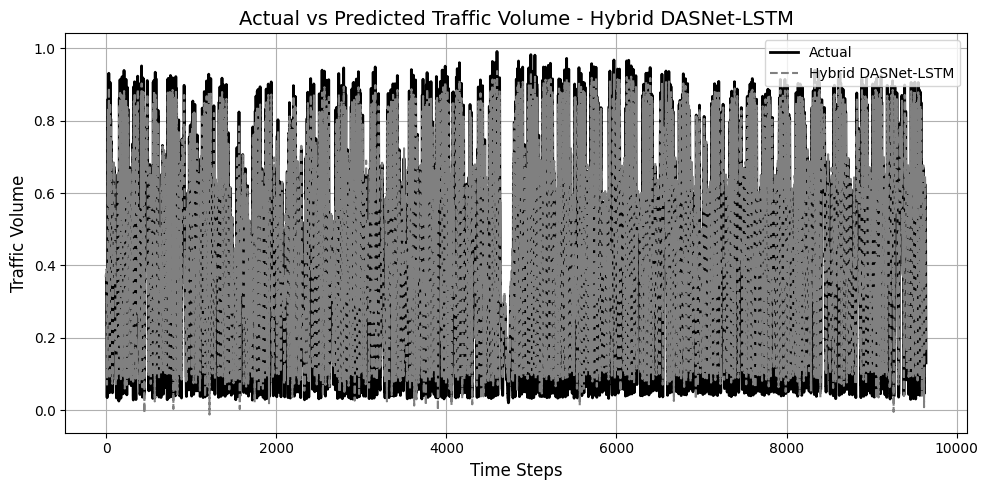

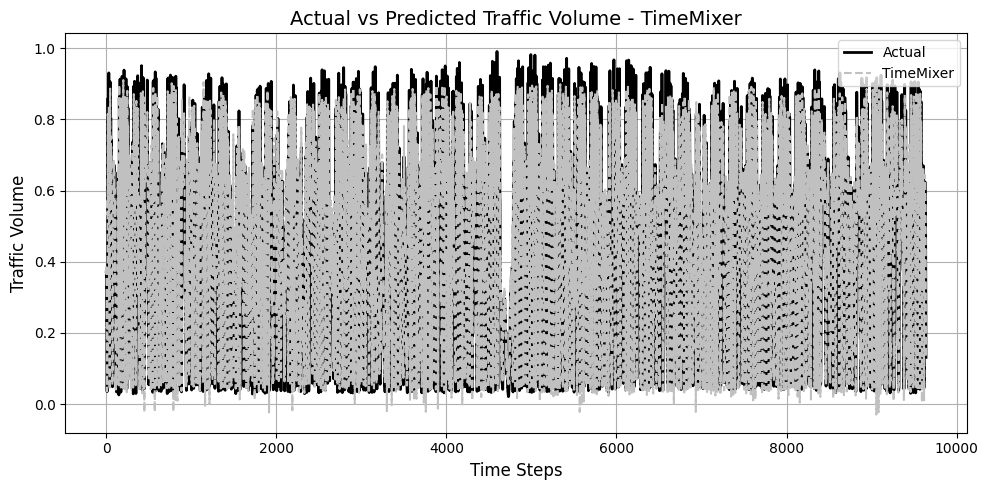

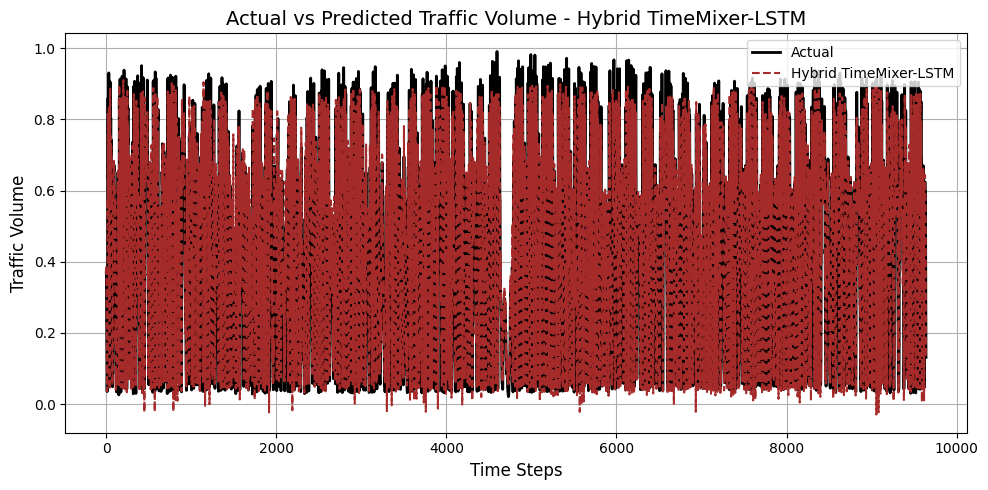

In [ ]:
def plot_model_predictions(y_actual, y_pred, model_name, color='blue'):
    plt.figure(figsize=(10, 5))
    plt.plot(y_actual, label="Actual", color='black', linewidth=2)
    plt.plot(y_pred, label=model_name, linestyle='dashed', color=color)
    plt.title(f"Actual vs Predicted Traffic Volume - {model_name}", fontsize=14)
    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function for each model
plot_model_predictions(y_test_actual_inv, y_pred_lstm, "LSTM", color='blue')
plot_model_predictions(y_test_actual_inv, y_pred_arima, "ARIMA", color='red')
plot_model_predictions(y_test_actual_inv, y_pred_tsmixer, "TSMixer", color='green')
plot_model_predictions(y_test_actual_inv, y_test_pred_inv, "Hybrid LSTM-TSMixer", color='purple')
plot_model_predictions(y_test_actual_inv, y_pred_knn_lstm, "KNN-LSTM", color='orange')
plot_model_predictions(y_test_actual_inv, y_pred_actual_Dasnet, "DASNet", color='pink')
plot_model_predictions(y_test_actual_inv, y_pred_Dasnet_LSTM, "Hybrid DASNet-LSTM", color='gray')
plot_model_predictions(y_test_actual_inv, y_pred_TimeMixer, "TimeMixer", color='silver')
plot_model_predictions(y_test_actual_inv, y_pred_TimeMixer_LSTM, "Hybrid TimeMixer-LSTM", color='brown')

In [ ]:
# Display predicted vs actual values (first 10 entries) for each model using .iloc

def print_predictions(model_name, y_true, y_pred):
    print(f"\n📌 {model_name} Predictions (First 10 Samples)")
    print("-" * 50)
    for i in range(10):
        actual = y_true[i] if isinstance(y_true, np.ndarray) else y_true.iloc[i]
        print(f"Actual: {actual:.2f} | Predicted: {y_pred[i]:.2f}")

# Display predictions
print_predictions("LSTM", y_test_actual_inv, y_pred_lstm)
#print_predictions("ARIMA", y_test_actual_inv, y_pred_arima)
print_predictions("TSMixer", y_test_actual_inv, y_pred_tsmixer)
print_predictions("Hybrid LSTM-TSMixer", y_test_actual_inv, y_test_pred_inv)
print_predictions("KNN-LSTM", y_test_actual_inv, y_pred_knn_lstm.flatten())
print_predictions("DASNet", y_test_actual_inv, y_pred_actual_Dasnet.flatten())
print_predictions("Hybrid DASNet-LSTM", y_test_actual_inv, y_pred_Dasnet_LSTM.flatten())
print_predictions("TimeMixer", y_test_actual_inv, y_pred_TimeMixer.flatten())
print_predictions("Hybrid TimeMixer-LSTM", y_test_actual_inv, y_pred_TimeMixer_LSTM.flatten())



📌 LSTM Predictions (First 10 Samples)
--------------------------------------------------
Actual: 0.37 | Predicted: 0.35
Actual: 0.37 | Predicted: 0.36
Actual: 0.30 | Predicted: 0.36
Actual: 0.30 | Predicted: 0.26
Actual: 0.24 | Predicted: 0.28
Actual: 0.24 | Predicted: 0.20
Actual: 0.15 | Predicted: 0.21
Actual: 0.08 | Predicted: 0.13
Actual: 0.05 | Predicted: 0.09
Actual: 0.03 | Predicted: 0.08

📌 TSMixer Predictions (First 10 Samples)
--------------------------------------------------
Actual: 0.37 | Predicted: 0.37
Actual: 0.37 | Predicted: 0.36
Actual: 0.30 | Predicted: 0.38
Actual: 0.30 | Predicted: 0.34
Actual: 0.24 | Predicted: 0.29
Actual: 0.24 | Predicted: 0.27
Actual: 0.15 | Predicted: 0.22
Actual: 0.08 | Predicted: 0.15
Actual: 0.05 | Predicted: 0.10
Actual: 0.03 | Predicted: 0.08

📌 Hybrid LSTM-TSMixer Predictions (First 10 Samples)
--------------------------------------------------
Actual: 0.37 | Predicted: 0.36
Actual: 0.37 | Predicted: 0.36
Actual: 0.30 | Predicted: 0.38

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Explainable AI**</p>

#Using LIME for XAI


In [16]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6b00752d65e7486537eb3a424cd4c7f0885f7e8c0205431dd9d17b4caeb23d1e
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [17]:
from lime.lime_tabular import LimeTabularExplainer

# Convert your DataFrame to a NumPy array
X_train_numpy = X_train.to_numpy()  # Convert DataFrame to NumPy array
y_train_numpy = y_train.to_numpy()  # Convert DataFrame to NumPy array (if needed)

# Create the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_numpy,  # Pass NumPy array instead of DataFrame
    mode='regression',
    training_labels=y_train_numpy,  # Pass NumPy array
    feature_names=X_train.columns  # Feature names from DataFrame
)

# Choose a sample for explanation (e.g., the 10th sample in the test set)
i = 10
# Access the row by position using iloc
exp = explainer.explain_instance(X_test.iloc[i].to_numpy(), lambda x: hybrid_model(torch.tensor(x, dtype=torch.float32)).detach().numpy())

# Visualize the explanation
exp.show_in_notebook()


#Using PDP for XAI

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

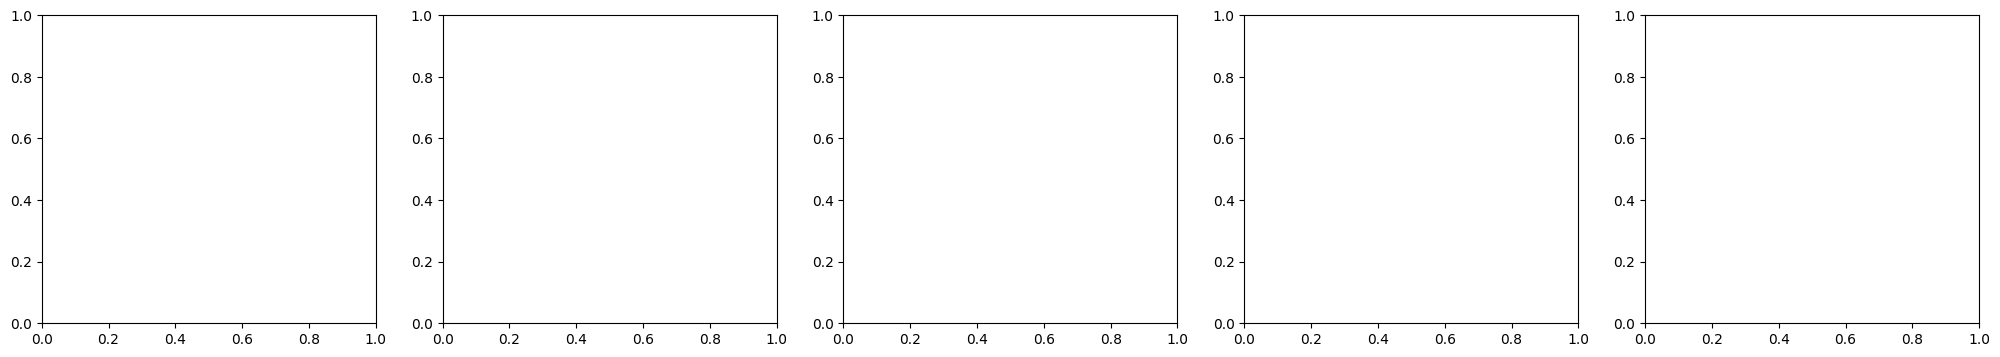

In [ ]:
# ----- 1. Convert X_test to numpy -----
X_test_np = X_test_torch.numpy() if isinstance(X_test_torch, torch.Tensor) else X_test_torch

# ----- 2. Features to plot -----
# Replace these with your actual feature names
feature_names = ['hour_of_day', 'day_of_week', 'previous_traffic_count', 'weather_condition', 'holiday_flag']
feature_indices = [0, 1, 2, 3, 4]  # corresponding column indices in X_test_np

# ----- 3. Manual PDP function -----
def compute_pdp(model, X, feature_idx, grid_points=50):
    values = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), grid_points)
    pdp = []
    for val in values:
        X_temp = X.copy()
        X_temp[:, feature_idx] = val  # set feature to fixed value
        with torch.no_grad():
            X_tensor = torch.tensor(X_temp, dtype=torch.float32)
            preds = model(X_tensor).squeeze().numpy()
        pdp.append(preds.mean())  # average over all samples
    return values, np.array(pdp)

# ----- 4. Plot PDPs -----
fig, axs = plt.subplots(1, len(feature_indices), figsize=(5*len(feature_indices), 4))
if len(feature_indices) == 1:
    axs = [axs]

for i, idx in enumerate(feature_indices):
    values, pdp_values = compute_pdp(hybrid_model, X_test_np, idx)
    axs[i].plot(values, pdp_values, color='blue')
    axs[i].set_xlabel(feature_names[i])
    axs[i].set_ylabel("Predicted Traffic")
    axs[i].set_title(f"PDP of {feature_names[i]}")
    axs[i].grid(True)

plt.tight_layout()
plt.show()


#permutation importance using XAI

In [ ]:

# Wrap the model for sklearn compatibility (if using hybrid model, replace with your actual model)
class HybridModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, hybrid_model):
        self.hybrid_model = hybrid_model

    def fit(self, X, y):
        X_tensor = torch.tensor(X.values, dtype=torch.float32)  # Convert to NumPy array first
        y_tensor = torch.tensor(y.values, dtype=torch.float32)  # Assuming y is a pandas Series
        self.hybrid_model.train_model(X_tensor, y_tensor)  # Replace with your training logic
        return self

    def predict(self, X):
        X_numpy = X.values  # Convert DataFrame to NumPy array
        X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
        with torch.no_grad():
            preds = self.hybrid_model(X_tensor).squeeze().numpy()
        return preds

# Wrap the hybrid model
hybrid_model_wrapper = HybridModelWrapper(hybrid_model)

# Step 1: Compute Permutation Importance
result = permutation_importance(hybrid_model_wrapper, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Step 2: Get the importance scores for each feature
importance_scores = result.importances_mean

# Step 3: Plot the permutation importance
fig, ax = plt.subplots(figsize=(8, 5))

# Sort importance scores in ascending order
sorted_idx = importance_scores.argsort()

# Plot the bar chart for feature importance
ax.barh(range(len(sorted_idx)), importance_scores[sorted_idx], align="center")
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(X_test.columns[sorted_idx])  # Use actual feature names from X_test
ax.set_xlabel("Permutation Importance")
ax.set_title("Feature Importance via Permutation")

# Display the plot
plt.show()

NameError: name 'BaseEstimator' is not defined

#K Fold Validation


**Validation of LSTM**

In [ ]:
# Example: Assuming df is your prepared DataFrame
X = df.drop(columns=['traffic_volume']).values  # Features
y = df['traffic_volume'].values  # Target (traffic volume)

# Convert to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

# Define the number of splits (K)
tscv = TimeSeriesSplit(n_splits=5)  # You can change n_splits to any desired value


Training for Fold 1...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0876 - val_loss: 0.0407
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0350 - val_loss: 0.0383
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0333 - val_loss: 0.0345
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0313 - val_loss: 0.0349
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0314 - val_loss: 0.0346
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0312 - val_loss: 0.0322
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0295 - val_loss: 0.0306
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0273 - val_loss: 0.0230
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0213 - val_loss: 0.0184
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/ste

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0756 - val_loss: 0.0360
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0355 - val_loss: 0.0345
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0347 - val_loss: 0.0330
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0324 - val_loss: 0.0290
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0259 - val_loss: 0.0195
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0196 - val_loss: 0.0169
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 9/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 10/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 11/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 12/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/ste

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0621 - val_loss: 0.0280
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0350 - val_loss: 0.0259
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0320 - val_loss: 0.0155
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0202 - val_loss: 0.0091
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0155 - val_loss: 0.0101
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0140 - val_loss: 0.0074
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0129 - val_loss: 0.0093
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0126 - val_loss: 0.0067
Epoch 9/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0121 - val_loss: 0.0063
Epoch 10/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0115 - val_loss: 0.0064
Epoch 11/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0112 - val_loss: 0.0062
Epoch 12/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 24

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0533 - val_loss: 0.0272
Epoch 2/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0310 - val_loss: 0.0161
Epoch 3/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0189 - val_loss: 0.0080
Epoch 4/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0140 - val_loss: 0.0071
Epoch 5/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0123 - val_loss: 0.0068
Epoch 6/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0116 - val_loss: 0.0074
Epoch 7/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0108 - val_loss: 0.0075
Epoch 8/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 9/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0104 - val_loss: 0.0058
Epoch 10/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 11/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0097 - val_loss: 0.0053
Epoch 12/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 0.0535 - val_loss: 0.0255
Epoch 2/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0299 - val_loss: 0.0104
Epoch 3/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0153 - val_loss: 0.0067
Epoch 4/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0116 - val_loss: 0.0059
Epoch 5/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0106 - val_loss: 0.0057
Epoch 6/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0104 - val_loss: 0.0061
Epoch 7/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0100 - val_loss: 0.0061
Epoch 8/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0092 - val_loss: 0.0057
Epoch 9/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 10/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0088 - val_loss: 0.0049
Epoch 11/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0085 - val_loss: 0.0048
Epoch 12/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 

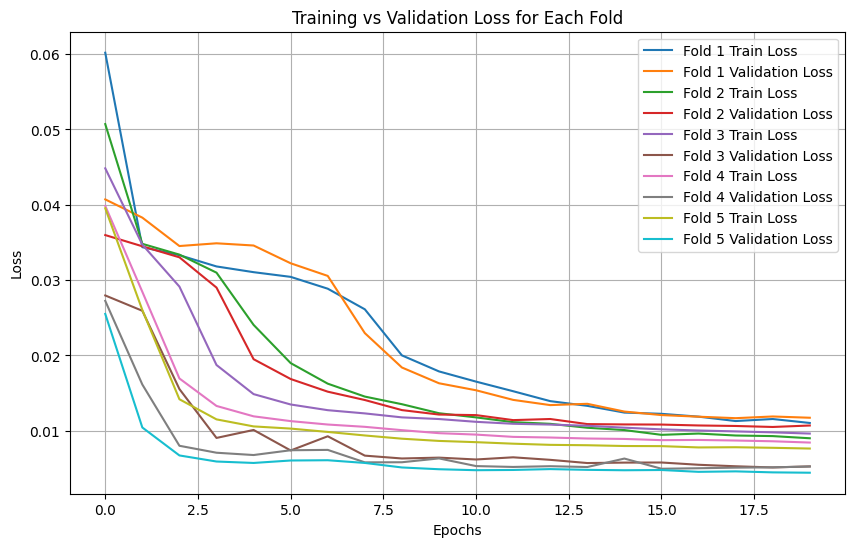

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# List to store the history of training and validation losses for each fold
histories = []

# Lists to store the metrics for each fold
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"Training for Fold {fold}...")

    # Split the data into training and testing sets
    X_train, X_test = X_torch[train_idx], X_torch[test_idx]
    y_train, y_test = y_torch[train_idx], y_torch[test_idx]

    # Define the model
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    # Reshape the data to fit LSTM input (samples, time_steps, features)
    X_train_reshaped = X_train.unsqueeze(2).numpy()  # Add time dimension
    X_test_reshaped = X_test.unsqueeze(2).numpy()

    # Train the model
    history = lstm_model.fit(X_train_reshaped, y_train.numpy(), epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test.numpy()))

    # Append the history to the histories list
    histories.append(history)

    # Predict using the trained model
    y_pred = lstm_model.predict(X_test_reshaped)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test.numpy(), y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test.numpy(), y_pred)
    r2 = r2_score(y_test.numpy(), y_pred)

    # Append metrics for this fold
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"Fold {fold} Metrics - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# Calculate average metrics
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mae = np.mean(mae_list)
avg_r2 = np.mean(r2_list)

print(f"\nAverage Metrics Across All Folds:")
print(f"Average MSE: {avg_mse}")
print(f"Average RMSE: {avg_rmse}")
print(f"Average MAE: {avg_mae}")
print(f"Average R²: {avg_r2}")

# Optionally plot losses for each fold
plt.figure(figsize=(10, 6))
for fold, history in enumerate(histories, 1):
    plt.plot(history.history['loss'], label=f"Fold {fold} Train Loss")
    plt.plot(history.history['val_loss'], label=f"Fold {fold} Validation Loss")

plt.title('Training vs Validation Loss for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


**TSMIXER**

Training for Fold 1...
Fold 1 - MSE: 0.0114720668643713, RMSE: 0.10710773484847534, MAE: 0.07774382084608078, R²: 0.8455710411071777
Training for Fold 2...
Fold 2 - MSE: 0.010003319010138512, RMSE: 0.10001659367394249, MAE: 0.0682549700140953, R²: 0.8655280470848083
Training for Fold 3...
Fold 3 - MSE: 0.013040849938988686, RMSE: 0.11419654083635233, MAE: 0.08167286217212677, R²: 0.8259414434432983
Training for Fold 4...
Fold 4 - MSE: 0.01765705831348896, RMSE: 0.13287986421384151, MAE: 0.09802524000406265, R²: 0.7629627585411072
Training for Fold 5...
Fold 5 - MSE: 0.014385105110704899, RMSE: 0.11993792190422885, MAE: 0.08640992641448975, R²: 0.8064371347427368

Average Metrics across all folds:
Average MSE: 0.013311679847538472
Average RMSE: 0.1148277310953681
Average MAE: 0.08242136389017105
Average R²: 0.8212880849838257


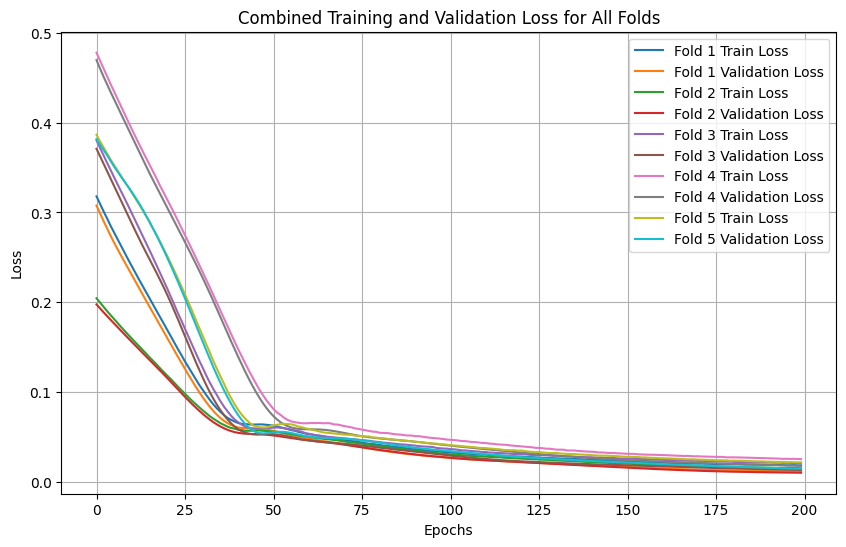

In [ ]:
# TSMixer Model Definition
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Assuming X and y are numpy arrays
# Convert data to Torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)  # Directly use the numpy array X
y_torch = torch.tensor(y, dtype=torch.float32)  # Directly use the numpy array y

# Normalize the features (only X, not y)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_torch.numpy())  # Normalize using sklearn's MinMaxScaler
X_torch = torch.tensor(X_scaled, dtype=torch.float32)  # Convert back to torch tensor

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store loss values and metrics for each fold
all_train_losses = []
all_val_losses = []
metrics = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}

# 5-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_torch), 1):
    print(f"Training for Fold {fold}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_torch[train_idx], X_torch[val_idx]
    y_train_fold, y_val_fold = y_torch[train_idx], y_torch[val_idx]

    # Initialize the model for each fold
    tsmixer_model = TSMixer(X_train_fold.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)

    # Lists to track losses for the current fold
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(200):
        tsmixer_model.train()  # Set model to training mode
        optimizer.zero_grad()  # Clear the gradients
        outputs = tsmixer_model(X_train_fold).squeeze()  # Forward pass
        loss = criterion(outputs, y_train_fold)  # Compute training loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Track training loss
        train_losses.append(loss.item())

        # Validation loss
        tsmixer_model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No need to compute gradients for validation
            val_outputs = tsmixer_model(X_val_fold).squeeze()
            val_loss = criterion(val_outputs, y_val_fold)

        # Track validation loss
        val_losses.append(val_loss.item())

    # Store fold losses
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Calculate metrics after each fold
    with torch.no_grad():
        y_pred_fold = tsmixer_model(X_val_fold).squeeze().numpy()

    mse = mean_squared_error(y_val_fold.numpy(), y_pred_fold)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_fold.numpy(), y_pred_fold)
    r2 = r2_score(y_val_fold.numpy(), y_pred_fold)

    metrics['MSE'].append(mse)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    metrics['R2'].append(r2)

    print(f"Fold {fold} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# After all folds, calculate and print average metrics
avg_metrics = {key: np.mean(val) for key, val in metrics.items()}
print(f"\nAverage Metrics across all folds:")
print(f"Average MSE: {avg_metrics['MSE']}")
print(f"Average RMSE: {avg_metrics['RMSE']}")
print(f"Average MAE: {avg_metrics['MAE']}")
print(f"Average R²: {avg_metrics['R2']}")

# Combined plot of training and validation loss for all folds
plt.figure(figsize=(10, 6))

# Plot training and validation losses for each fold
for fold in range(5):
    plt.plot(all_train_losses[fold], label=f'Fold {fold+1} Train Loss')
    plt.plot(all_val_losses[fold], label=f'Fold {fold+1} Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Combined Training and Validation Loss for All Folds')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Optionally: Train on the entire dataset and make predictions
tsmixer_model = TSMixer(X_torch.shape[1])  # Re-initialize model
optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)
tsmixer_model.train()

# Train on the entire dataset
optimizer.zero_grad()
outputs = tsmixer_model(X_torch).squeeze()  # Forward pass
loss = criterion(outputs, y_torch)  # Compute total loss
loss.backward()  # Backpropagation
optimizer.step()  # Update model parameters

# Making predictions with the trained model
y_pred_tsmixer = tsmixer_model(X_torch).detach().numpy().flatten()  # Make predictions


**Hybrid TSMixer LSTM**

Training for Fold 1...


/tmp/ipython-input-1056227085.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_torch = torch.tensor(X_val_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:90: UserWarning: To copy construct from a tensor, it is recommended to use

Fold 1 - MSE: 0.005314548499882221, RMSE: 0.07290094992441608, MAE: 0.04490244388580322, R²: 0.9283350706100464
Training for Fold 2...


/tmp/ipython-input-1056227085.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_torch = torch.tensor(X_val_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:90: UserWarning: To copy construct from a tensor, it is recommended to use

Fold 2 - MSE: 0.005272997077554464, RMSE: 0.07261540523576566, MAE: 0.04567451402544975, R²: 0.9294352531433105
Training for Fold 3...


/tmp/ipython-input-1056227085.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_torch = torch.tensor(X_val_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:90: UserWarning: To copy construct from a tensor, it is recommended to use

Fold 3 - MSE: 0.0049352808855473995, RMSE: 0.07025155432833781, MAE: 0.04553370922803879, R²: 0.9340798854827881
Training for Fold 4...


/tmp/ipython-input-1056227085.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_torch = torch.tensor(X_val_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:90: UserWarning: To copy construct from a tensor, it is recommended to use

Fold 4 - MSE: 0.005781387444585562, RMSE: 0.07603543545338293, MAE: 0.04591135308146477, R²: 0.924163281917572
Training for Fold 5...


/tmp/ipython-input-1056227085.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_torch = torch.tensor(X_val_fold, dtype=torch.float32)
/tmp/ipython-input-1056227085.py:90: UserWarning: To copy construct from a tensor, it is recommended to use

Fold 5 - MSE: 0.005435444414615631, RMSE: 0.07372546652694462, MAE: 0.04572227597236633, R²: 0.9262732267379761

Average Metrics across all folds:
Average MSE: 0.005347931664437056
Average RMSE: 0.07310576229376942
Average MAE: 0.045548859238624576
Average R²: 0.9284573435783386


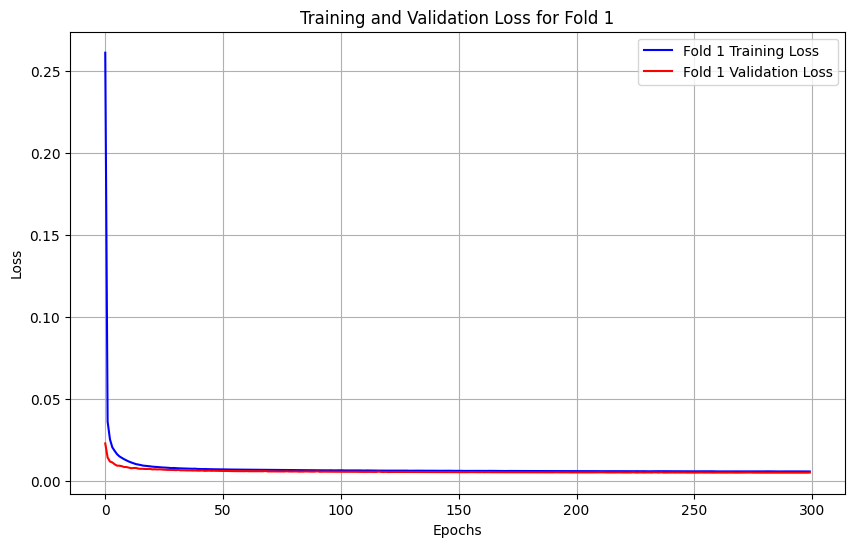

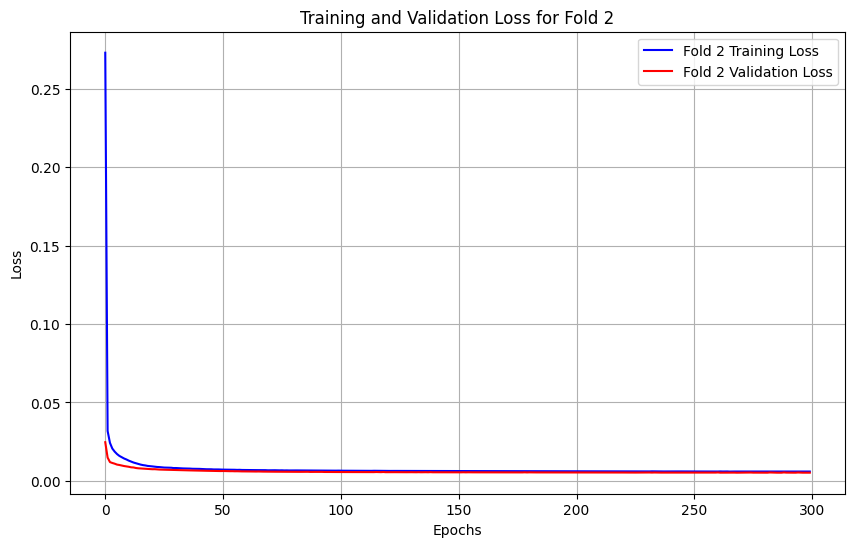

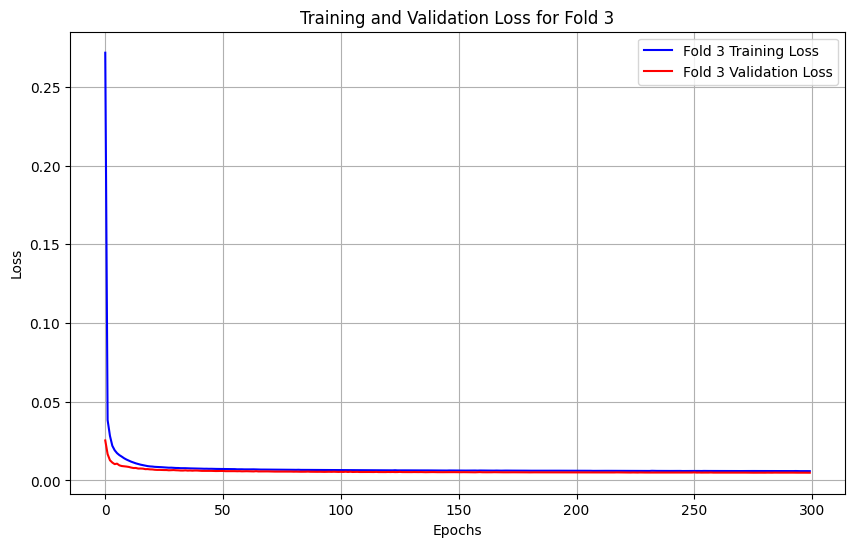

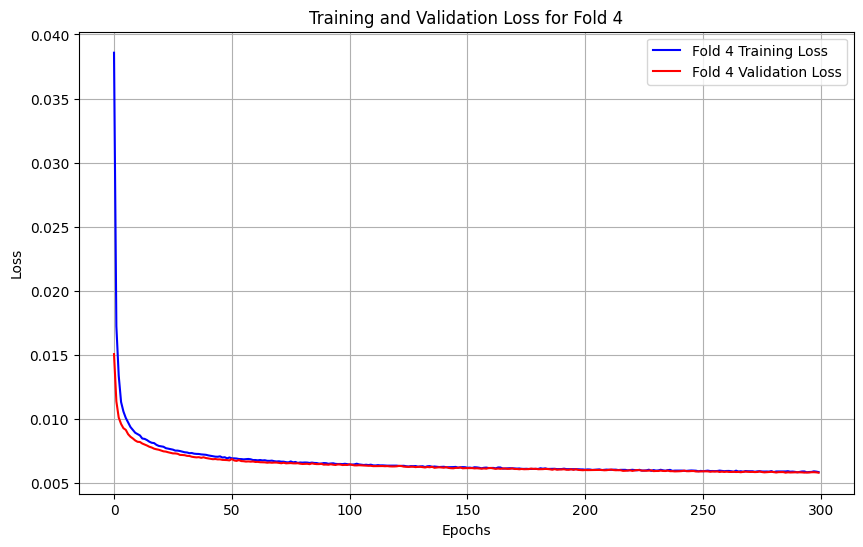

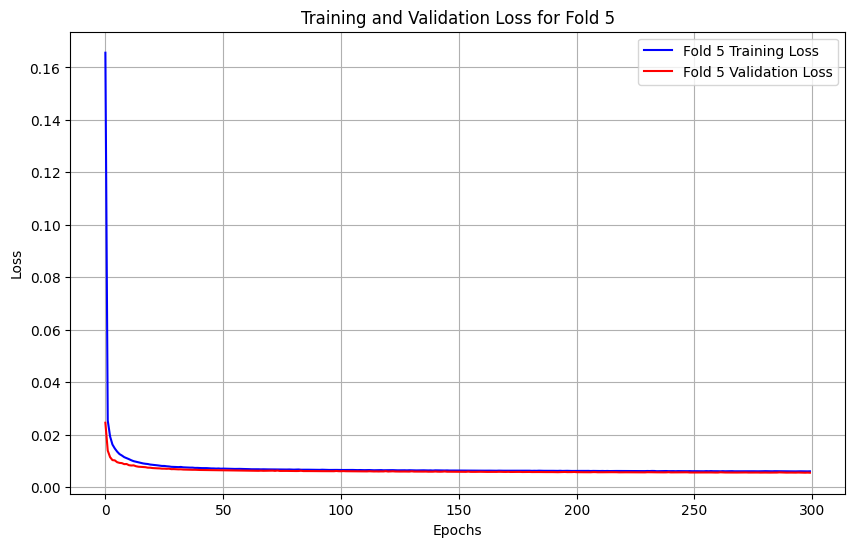

In [ ]:
# ========================
# 1 DEFINE LSTM MODEL
# ========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x)  # Pass through LSTM
        x = self.fc(x[:, -1, :])  # Get the last timestep output and pass it to the fully connected layer
        return x

# ========================
# 2 DEFINE TSMixer MODEL
# ========================
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# ========================
# 3 HYBRID MODEL (LSTM + TSMixer)
# ========================
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.lstm = LSTMModel(input_dim)
        self.tsmixer = TSMixer(input_dim)
        self.fc = nn.Linear(2, 1)  # Combine both outputs

    def forward(self, x):
        lstm_out = self.lstm(x)  # LSTM output
        tsmixer_out = self.tsmixer(x)  # TSMixer output

        # Flatten LSTM output to match the shape of TSMixer output (batch_size, 1)
        lstm_out = lstm_out.view(-1, 1)  # Reshape LSTM output to (batch_size, 1)

        # Ensure the TSMixer output is also (batch_size, 1)
        tsmixer_out = tsmixer_out.view(-1, 1)

        combined = torch.cat((lstm_out, tsmixer_out), dim=1)  # Concatenate outputs from both models
        return self.fc(combined)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store loss values for plotting
all_train_losses = []
all_val_losses = []
metrics = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}

# ========================
# 4 TRAINING AND CROSS-VALIDATION
# ========================
criterion = nn.MSELoss()

# Initialize the model, optimizer for each fold
batch_size = 64
num_epochs = 300

train_losses = []
val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"Training for Fold {fold}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Convert to torch tensors
    X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32)
    X_val_torch = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_torch = torch.tensor(y_val_fold, dtype=torch.float32)

    # Reshape to (batch_size, sequence_length, features)
    X_train_torch = X_train_torch.unsqueeze(1)  # Add sequence_length dimension (1 for tabular data)
    X_val_torch = X_val_torch.unsqueeze(1)  # Add sequence_length dimension

    # Initialize the model for each fold
    hybrid_model = HybridModel(X_train_torch.shape[2])  # Input dim is the number of features
    optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)

    # Lists to track losses for the current fold
    fold_train_losses = []
    fold_val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        hybrid_model.train()
        epoch_loss = 0

        # Mini-batch training loop
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = hybrid_model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        fold_train_losses.append(epoch_loss / len(train_loader))  # Store training loss

        # Validation loss
        hybrid_model.eval()
        with torch.no_grad():
            val_outputs = hybrid_model(X_val_torch).squeeze()  # Make predictions on validation data
            val_loss = criterion(val_outputs, y_val_torch)
            fold_val_losses.append(val_loss.item())  # Store validation loss

    # Store fold losses
    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)

    # Calculate metrics after each fold
    with torch.no_grad():
        y_pred_fold = hybrid_model(X_val_torch).squeeze().numpy()

    mse = mean_squared_error(y_val_torch.numpy(), y_pred_fold)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_torch.numpy(), y_pred_fold)
    r2 = r2_score(y_val_torch.numpy(), y_pred_fold)

    metrics['MSE'].append(mse)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    metrics['R2'].append(r2)

    print(f"Fold {fold} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# After all folds, calculate and print average metrics
avg_metrics = {key: np.mean(val) for key, val in metrics.items()}
print(f"\nAverage Metrics across all folds:")
print(f"Average MSE: {avg_metrics['MSE']}")
print(f"Average RMSE: {avg_metrics['RMSE']}")
print(f"Average MAE: {avg_metrics['MAE']}")
print(f"Average R²: {avg_metrics['R2']}")

# ==========================
# PLOT TRAINING AND VALIDATION LOSS FOR EACH FOLD
# ==========================
for fold in range(5):
    plt.figure(figsize=(10, 6))
    plt.plot(all_train_losses[fold], label=f'Fold {fold+1} Training Loss', color='blue')
    plt.plot(all_val_losses[fold], label=f'Fold {fold+1} Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for Fold {fold+1}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Optionally: Train on the entire dataset and make predictions
hybrid_model = HybridModel(X_train.shape[1])  # Re-initialize model
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)
hybrid_model.train()

# Train on the entire dataset
optimizer.zero_grad()
outputs = hybrid_model(X_train_torch).squeeze()  # Forward pass
loss = criterion(outputs, y_train_torch)  # Compute total loss
loss.backward()  # Backpropagation
optimizer.step()  # Update model parameters

# Making predictions with the trained model
y_pred_hybrid = hybrid_model(X_train_torch).detach().numpy().flatten()  # Make predictions

**Hybrid KNN LSTM**

Training for Fold 1...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0675 - val_loss: 0.0047
Epoch 2/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 3/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 4/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 5/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 6/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 7/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 8/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 9/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 10/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0072 - val_loss: 0.0042
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 1 - MSE: 0.004240347072482109, RMSE: 0.06511794739149959, MAE: 0.044267453253269196,

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0647 - val_loss: 0.0047
Epoch 2/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 3/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0077 - val_loss: 0.0046
Epoch 4/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 5/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 6/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 7/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 8/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 9/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 10/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0065 - val_loss: 0.0043
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 2 - MSE: 0.0043449304066598415, RMSE: 0.06591608609937215, MAE: 0.043594833463430405

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0649 - val_loss: 0.0041
Epoch 2/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0086 - val_loss: 0.0047
Epoch 3/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0081 - val_loss: 0.0041
Epoch 4/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 5/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 6/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0072 - val_loss: 0.0040
Epoch 7/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 8/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 9/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 10/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0070 - val_loss: 0.0040
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3 - MSE: 0.004003477748483419, RMSE: 0.0632730412457266, MAE: 0.0429491363465786, R²

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0604 - val_loss: 0.0057
Epoch 2/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 3/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 4/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 5/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 6/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 7/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 8/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 9/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 10/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0066 - val_loss: 0.0048
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 4 - MSE: 0.0047729588113725185, RMSE: 0.0690866037041373, MAE: 0.04480556398630142,

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0578 - val_loss: 0.0056
Epoch 2/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0083 - val_loss: 0.0046
Epoch 3/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 4/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 5/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 6/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 7/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 8/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 9/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 10/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0068 - val_loss: 0.0046
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 5 - MSE: 0.0046023218892514706, RMSE: 0.06784041486644572, MAE: 0.04431113600730896,

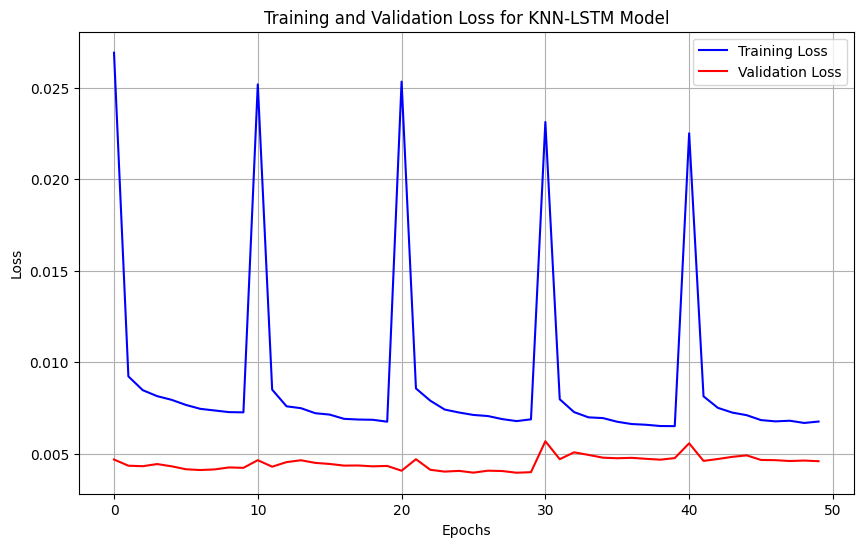

In [ ]:
# ========================
# KNN MODEL FOR FEATURE SELECTION
# ========================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
X_train_knn = knn.predict(X_train).reshape(-1, 1)
X_test_knn = knn.predict(X_test).reshape(-1, 1)

# ========================
# KNN-LSTM MODEL
# ========================
def build_knn_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_knn_lstm = np.reshape(X_train_knn, (X_train_knn.shape[0], 1, 1))
X_test_knn_lstm = np.reshape(X_test_knn, (X_test_knn.shape[0], 1, 1))

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store loss values for combined plot
all_train_losses = []
all_val_losses = []
metrics = {'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}

# ========================
# TRAINING AND CROSS-VALIDATION
# ========================
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_knn), 1):
    print(f"Training for Fold {fold}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_knn[train_idx], X_train_knn[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Reshape for LSTM
    X_train_knn_lstm_fold = np.reshape(X_train_fold, (X_train_fold.shape[0], 1, 1))
    X_val_knn_lstm_fold = np.reshape(X_val_fold, (X_val_fold.shape[0], 1, 1))

    # Build KNN-LSTM model
    knn_lstm_model = build_knn_lstm_model((1, 1))

    # Fit the model with training data and validation data
    history = knn_lstm_model.fit(X_train_knn_lstm_fold, y_train_fold, epochs=10, batch_size=32, verbose=1, validation_data=(X_val_knn_lstm_fold, y_val_fold))

    # Track losses for the current fold
    all_train_losses.extend(history.history['loss'])
    all_val_losses.extend(history.history['val_loss'])

    # Calculate metrics after each fold
    y_pred_fold = knn_lstm_model.predict(X_val_knn_lstm_fold)

    mse = mean_squared_error(y_val_fold, y_pred_fold)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)

    metrics['MSE'].append(mse)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    metrics['R2'].append(r2)

    print(f"Fold {fold} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# After all folds, calculate and print average metrics
avg_metrics = {key: np.mean(val) for key, val in metrics.items()}
print(f"\nAverage Metrics across all folds:")
print(f"Average MSE: {avg_metrics['MSE']}")
print(f"Average RMSE: {avg_metrics['RMSE']}")
print(f"Average MAE: {avg_metrics['MAE']}")
print(f"Average R²: {avg_metrics['R2']}")

# ==========================
# PLOT TRAINING AND VALIDATION LOSS FOR EACH FOLD
# ==========================
plt.figure(figsize=(10, 6))
plt.plot(all_train_losses, label='Training Loss', color='blue')
plt.plot(all_val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for KNN-LSTM Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()


**TimeMixer**


=== Fold 1 ===
Epoch 50/200 | Val Loss: 0.0111
Epoch 100/200 | Val Loss: 0.0084
Epoch 150/200 | Val Loss: 0.0077
Epoch 200/200 | Val Loss: 0.0074

=== Fold 2 ===
Epoch 50/200 | Val Loss: 0.0166
Epoch 100/200 | Val Loss: 0.0095
Epoch 150/200 | Val Loss: 0.0088
Epoch 200/200 | Val Loss: 0.0083

=== Fold 3 ===
Epoch 50/200 | Val Loss: 0.0238
Epoch 100/200 | Val Loss: 0.0119
Epoch 150/200 | Val Loss: 0.0103
Epoch 200/200 | Val Loss: 0.0095

=== Fold 4 ===
Epoch 50/200 | Val Loss: 0.0116
Epoch 100/200 | Val Loss: 0.0093
Epoch 150/200 | Val Loss: 0.0085
Epoch 200/200 | Val Loss: 0.0081

=== Fold 5 ===
Epoch 50/200 | Val Loss: 0.0125
Epoch 100/200 | Val Loss: 0.0096
Epoch 150/200 | Val Loss: 0.0090
Epoch 200/200 | Val Loss: 0.0086

=== Cross-Validation Results ===
Fold 1: MSE=0.0074, RMSE=0.0859, MAE=0.0583, R2=0.9006
Fold 2: MSE=0.0083, RMSE=0.0912, MAE=0.0629, R2=0.8882
Fold 3: MSE=0.0095, RMSE=0.0973, MAE=0.0693, R2=0.8736
Fold 4: MSE=0.0081, RMSE=0.0903, MAE=0.0602, R2=0.8906
Fold 5: MSE

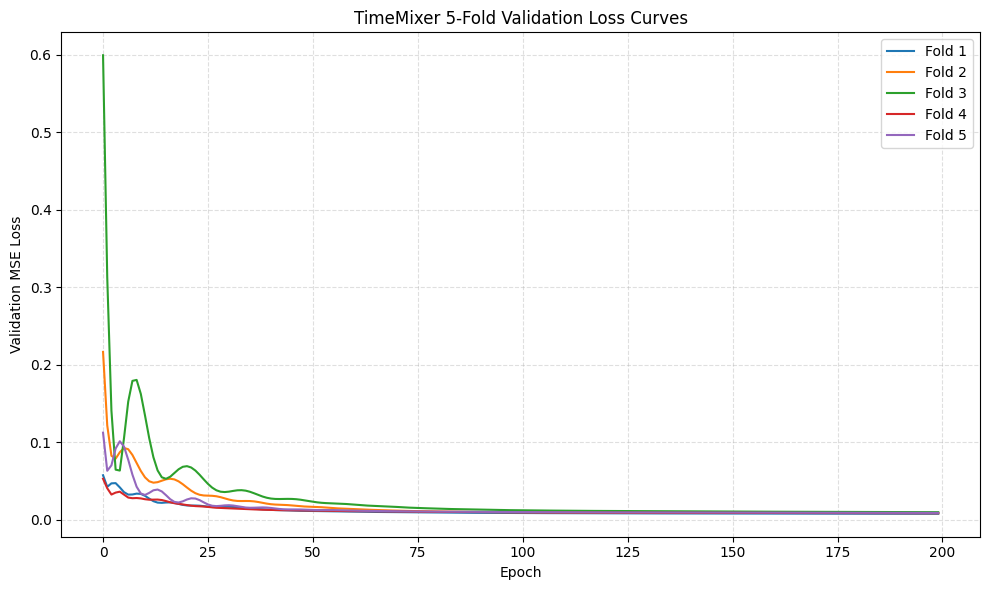

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- TimeMixer model ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

class TimeMixer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=3):
        super(TimeMixer, self).__init__()
        self.mixer_blocks = nn.Sequential(
            *[TimeMixerBlock(input_dim, hidden_dim) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.mixer_blocks(x)   # [batch, input_dim]
        x = self.output_layer(x)   # [batch, 1]
        return x.squeeze(-1)       # [batch]

# --- Prepare data ---
# Handle both pandas DataFrame and NumPy array cases
if hasattr(X, "values"):
    X_all = X.values.astype(np.float32)
    y_all = y.values.astype(np.float32)
else:
    X_all = X.astype(np.float32)
    y_all = y.astype(np.float32)

# Parameters
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 200
hidden_dim = 64
num_blocks = 3
lr = 0.001

# Storage
fold_metrics = []
fold_val_losses = []

# --- Cross-validation ---
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_all)):
    print(f"\n=== Fold {fold+1} ===")

    # Split
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y_all[train_idx], y_all[val_idx]

    # Torch tensors
    X_train_t = torch.tensor(X_train)
    y_train_t = torch.tensor(y_train).view(-1)
    X_val_t   = torch.tensor(X_val)
    y_val_t   = torch.tensor(y_val).view(-1)

    # Model, loss, optimizer
    input_dim = X_train.shape[1]
    model = TimeMixer(input_dim=input_dim,
                      hidden_dim=hidden_dim,
                      num_blocks=num_blocks)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Track validation loss
    val_losses = []

    for epoch in range(epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t)

        val_losses.append(float(val_loss.item()))

        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Val Loss: {val_loss.item():.4f}")

    fold_val_losses.append(val_losses)

    # Predictions for metrics
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_t).numpy()
        y_true = y_val_t.numpy()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    fold_metrics.append({
        "Fold": fold+1,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

# --- Print metrics ---
print("\n=== Cross-Validation Results ===")
for m in fold_metrics:
    print(f"Fold {m['Fold']}: "
          f"MSE={m['MSE']:.4f}, RMSE={m['RMSE']:.4f}, "
          f"MAE={m['MAE']:.4f}, R2={m['R2']:.4f}")

# --- Average metrics ---
avg_mse  = np.mean([m['MSE']  for m in fold_metrics])
avg_rmse = np.mean([m['RMSE'] for m in fold_metrics])
avg_mae  = np.mean([m['MAE']  for m in fold_metrics])
avg_r2   = np.mean([m['R2']   for m in fold_metrics])

print("\n=== Average Across 5 Folds ===")
print(f"MSE={avg_mse:.4f}, RMSE={avg_rmse:.4f}, MAE={avg_mae:.4f}, R2={avg_r2:.4f}")

# --- Plot validation curves for all folds ---
plt.figure(figsize=(10, 6))
for i, losses in enumerate(fold_val_losses):
    plt.plot(losses, label=f"Fold {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE Loss")
plt.title("TimeMixer 5-Fold Validation Loss Curves")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Hybrid TimeMixer LSTM

[Fold 1] Epoch 10/100 | train 0.0069 | val 0.0058
[Fold 1] Epoch 20/100 | train 0.0067 | val 0.0059
[Fold 1] Epoch 30/100 | train 0.0063 | val 0.0058
[Fold 1] Epoch 40/100 | train 0.0063 | val 0.0065
[Fold 1] Epoch 50/100 | train 0.0062 | val 0.0054
[Fold 1] Epoch 60/100 | train 0.0061 | val 0.0054
[Fold 1] Epoch 70/100 | train 0.0060 | val 0.0056
[Fold 1] Epoch 80/100 | train 0.0059 | val 0.0053
[Fold 1] Epoch 90/100 | train 0.0059 | val 0.0058
[Fold 1] Epoch 100/100 | train 0.0059 | val 0.0053
[Fold 1] MSE 0.0053 | RMSE 0.0727 | MAE 0.0461 | R2 0.9296
[Fold 2] Epoch 10/100 | train 0.0068 | val 0.0077
[Fold 2] Epoch 20/100 | train 0.0066 | val 0.0060
[Fold 2] Epoch 30/100 | train 0.0063 | val 0.0058
[Fold 2] Epoch 40/100 | train 0.0062 | val 0.0067
[Fold 2] Epoch 50/100 | train 0.0061 | val 0.0063
[Fold 2] Epoch 60/100 | train 0.0060 | val 0.0063
[Fold 2] Epoch 70/100 | train 0.0059 | val 0.0058
[Fold 2] Epoch 80/100 | train 0.0059 | val 0.0058
[Fold 2] Epoch 90/100 | train 0.0059 | v

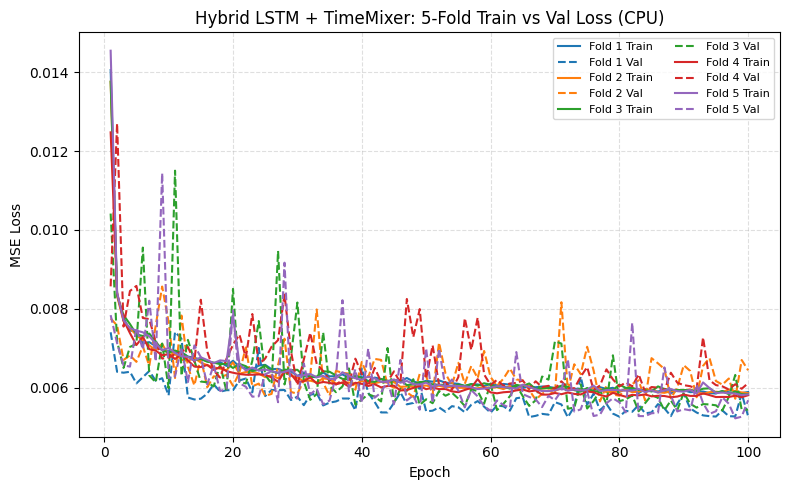


========== 5-FOLD METRICS ==========
Fold 1: MSE 0.0053 | RMSE 0.0727 | MAE 0.0461 | R2 0.9296
Fold 2: MSE 0.0064 | RMSE 0.0803 | MAE 0.0567 | R2 0.9127
Fold 3: MSE 0.0055 | RMSE 0.0739 | MAE 0.0484 | R2 0.9266
Fold 4: MSE 0.0061 | RMSE 0.0783 | MAE 0.0495 | R2 0.9177
Fold 5: MSE 0.0057 | RMSE 0.0754 | MAE 0.0504 | R2 0.9240
-------------------------------------
Average: MSE 0.0058 | RMSE 0.0761 | MAE 0.0502 | R2 0.9221


In [ ]:

def to_numpy(x):
    """Return ndarray from numpy or pandas objects."""
    try:
        # Pandas DataFrame/Series
        return x.to_numpy()
    except AttributeError:
        # Already numpy
        return np.asarray(x)

# Repro
torch.manual_seed(42)
np.random.seed(42)

# ------------------------
# Ingest data (train set for CV)
# ------------------------
Xn = to_numpy(X_train)   # shape [N, C] or [N, T, C] if you already windowed
yn = to_numpy(y_train).reshape(-1)

# If your inputs are [N, C], give LSTM a fake time axis T=1 -> [N, 1, C]
if Xn.ndim == 2:
    Xn = Xn[:, None, :]   # [N, 1, C]
elif Xn.ndim != 3:
    raise ValueError(f"X_train must be 2D or 3D. Got shape {Xn.shape}")

N, T, C = Xn.shape

X_full = torch.tensor(Xn, dtype=torch.float32)             # [N, T, C]
y_full = torch.tensor(yn, dtype=torch.float32).view(-1)    # [N]

# ------------------------
# TimeMixer blocks
# ------------------------
class TimeMixerBlock(nn.Module):
    """
    Note: This version mixes features on the [B, H] vector after LSTM pooling
    (same as your earlier code). It's not token-mixing across time since T=1.
    """
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):  # x: [B, D]
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

# ------------------------
# Hybrid LSTM + TimeMixer
# ------------------------
class HybridLSTMTimeMixer(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, tm_hidden=64, num_tm_blocks=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.tm_blocks = nn.Sequential(
            *[TimeMixerBlock(lstm_hidden, tm_hidden) for _ in range(num_tm_blocks)]
        )
        self.output_layer = nn.Linear(lstm_hidden, 1)

    def forward(self, x):        # x: [B, T, C]
        lstm_out, _ = self.lstm(x)      # [B, T, H]
        x = lstm_out[:, -1, :]          # take last step -> [B, H]  (T may be 1)
        x = self.tm_blocks(x)           # [B, H]
        out = self.output_layer(x)      # [B, 1]
        return out.squeeze(-1)          # [B]

# ------------------------
# CV config
# ------------------------
epochs = 100
batch_size = 64
lr = 1e-3
weight_decay = 1e-5
k_splits = 5
input_dim = C

all_train_curves = []
all_val_curves = []
fold_mse, fold_rmse, fold_mae, fold_r2 = [], [], [], []

# ------------------------
# 5-Fold loop
# ------------------------
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_full), start=1):
    X_tr, y_tr = X_full[tr_idx], y_full[tr_idx]
    X_va, y_va = X_full[va_idx], y_full[va_idx]

    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_va, y_va), batch_size=batch_size, shuffle=False)

    model = HybridLSTMTimeMixer(input_dim=input_dim, lstm_hidden=64, tm_hidden=64, num_tm_blocks=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []

    for ep in range(1, epochs + 1):
        # Train
        model.train()
        run = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            yp = model(xb)
            loss = criterion(yp, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            run += loss.item()
        train_loss = run / max(1, len(train_loader))
        train_losses.append(train_loss)

        # Val
        model.eval()
        vrun = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yp = model(xb)
                vrun += criterion(yp, yb).item()
        val_loss = vrun / max(1, len(val_loader))
        val_losses.append(val_loss)

        if ep % 10 == 0:
            print(f"[Fold {fold}] Epoch {ep}/{epochs} | train {train_loss:.4f} | val {val_loss:.4f}")

    all_train_curves.append(train_losses)
    all_val_curves.append(val_losses)

    # Fold metrics on validation
    model.eval()
    y_pred_fold, y_true_fold = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            yp = model(xb)
            y_pred_fold.append(yp.detach().numpy())
            y_true_fold.append(yb.detach().numpy())
    y_pred_fold = np.concatenate(y_pred_fold)
    y_true_fold = np.concatenate(y_true_fold)

    # Inverse-transform to original scale if target scaler exists in scope
    try:
        y_pred_eval = traffic_scaler.inverse_transform(y_pred_fold.reshape(-1, 1)).ravel()
        y_true_eval = traffic_scaler.inverse_transform(y_true_fold.reshape(-1, 1)).ravel()
    except Exception:
        y_pred_eval = y_pred_fold
        y_true_eval = y_true_fold

    mse = mean_squared_error(y_true_eval, y_pred_eval)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true_eval, y_pred_eval)
    r2  = r2_score(y_true_eval, y_pred_eval)

    fold_mse.append(mse); fold_rmse.append(rmse); fold_mae.append(mae); fold_r2.append(r2)
    print(f"[Fold {fold}] MSE {mse:.4f} | RMSE {rmse:.4f} | MAE {mae:.4f} | R2 {r2:.4f}")

# ------------------------
# Plot: single figure with all folds
# ------------------------
plt.figure(figsize=(8, 5))
colors = plt.cm.tab10.colors
x = np.arange(1, epochs + 1)

for i in range(k_splits):
    c = colors[i % len(colors)]
    plt.plot(x, all_train_curves[i], color=c, linestyle='-',  label=f'Fold {i+1} Train')
    plt.plot(x, all_val_curves[i],   color=c, linestyle='--', label=f'Fold {i+1} Val')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Hybrid LSTM + TimeMixer: 5-Fold Train vs Val Loss (CPU)')
plt.legend(ncol=2, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ------------------------
# Metrics summary
# ------------------------
avg_mse  = float(np.mean(fold_mse))
avg_rmse = float(np.mean(fold_rmse))
avg_mae  = float(np.mean(fold_mae))
avg_r2   = float(np.mean(fold_r2))

print("\n========== 5-FOLD METRICS ==========")
for i in range(k_splits):
    print(f"Fold {i+1}: MSE {fold_mse[i]:.4f} | RMSE {fold_rmse[i]:.4f} | MAE {fold_mae[i]:.4f} | R2 {fold_r2[i]:.4f}")
print("-------------------------------------")
print(f"Average: MSE {avg_mse:.4f} | RMSE {avg_rmse:.4f} | MAE {avg_mae:.4f} | R2 {avg_r2:.4f}")


**DASNET**

Fold 1
Epoch 1/20, Train Loss: 0.0263, Val Loss: 0.0085
--------------------------------------------------
Epoch 2/20, Train Loss: 0.0093, Val Loss: 0.0083
--------------------------------------------------
Epoch 3/20, Train Loss: 0.0086, Val Loss: 0.0075
--------------------------------------------------
Epoch 4/20, Train Loss: 0.0084, Val Loss: 0.0073
--------------------------------------------------
Epoch 5/20, Train Loss: 0.0080, Val Loss: 0.0077
--------------------------------------------------
Epoch 6/20, Train Loss: 0.0079, Val Loss: 0.0070
--------------------------------------------------
Epoch 7/20, Train Loss: 0.0078, Val Loss: 0.0067
--------------------------------------------------
Epoch 8/20, Train Loss: 0.0077, Val Loss: 0.0069
--------------------------------------------------
Epoch 9/20, Train Loss: 0.0076, Val Loss: 0.0066
--------------------------------------------------
Epoch 10/20, Train Loss: 0.0075, Val Loss: 0.0067
-------------------------------------------

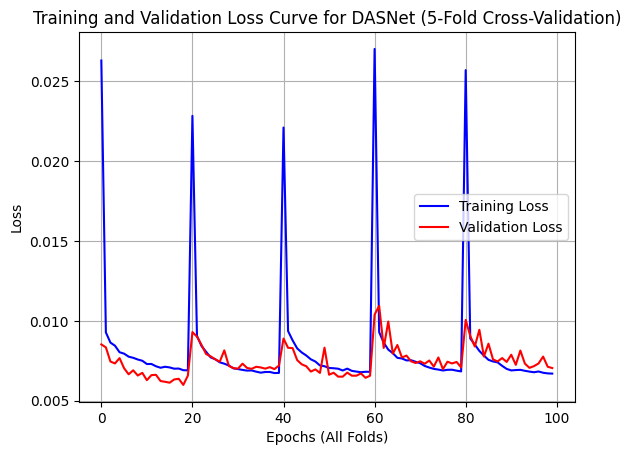

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# ----- DASNet -----
class DASNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, num_heads=4):
        super(DASNet, self).__init__()

        # Set input_size to input_dim to match the feature size in the data
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Temporal Self-Attention
        self.temporal_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        # Feature Self-Attention (custom linear attention over features)
        self.feature_attn = nn.Linear(hidden_dim, 1)

        # Fusion
        self.fc_fusion = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Ensure the input to LSTM is 3D: (B, T, F)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)

        # --- Temporal attention ---
        temp_attn_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out)
        temp_context = torch.mean(temp_attn_out, dim=1)  # (batch, hidden_dim)

        # --- Feature attention (soft attention across hidden_dim) ---
        feat_weights = torch.softmax(self.feature_attn(lstm_out), dim=1)  # (batch, seq_len, 1)
        feat_context = torch.sum(feat_weights * lstm_out, dim=1)  # (batch, hidden_dim)

        # --- Fusion ---
        fusion = torch.cat([temp_context, feat_context], dim=1)  # (batch, hidden_dim*2)
        fusion = torch.relu(self.fc_fusion(fusion))  # (batch, hidden_dim)

        out = self.fc_out(fusion)  # (batch, 1)
        return out.squeeze()


# ========================
#  Cross-Validation Setup
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix the input_dim based on the number of features in your dataset
# **CHANGE HERE**: Make sure input_dim matches your data shape
input_dim = 10  # If your data has 10 features (adjust this value accordingly)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_losses, val_losses = [], []

# Lists to store metrics for each fold
mse_list, rmse_list, mae_list, r2_list = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_torch)):
    print(f"Fold {fold + 1}")

    # Split data into train and validation for this fold
    X_train_fold, X_val_fold = X_train_torch[train_idx], X_train_torch[val_idx]
    y_train_fold, y_val_fold = y_train_torch[train_idx], y_train_torch[val_idx]

    # Create DataLoader for this fold
    # **CHANGE HERE**: Add unsqueeze to ensure data has 3D shape (B, T, F) for LSTM
    train_dataset = TensorDataset(X_train_fold.unsqueeze(1), y_train_fold)  # Add channel dimension if needed
    val_dataset = TensorDataset(X_val_fold.unsqueeze(1), y_val_fold)  # Add channel dimension if needed
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Model, optimizer, and loss function
    model = DASNet(input_dim=input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # ========================
    #  TRAINING LOOP
    # ========================
    fold_train_losses, fold_val_losses = [], []

    for epoch in range(20):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # **CHANGE HERE**: Ensure input to LSTM is 3D (B, T, F)
            if X_batch.dim() == 4:  # (B, T, W, F) -> (B, T, W*F)
                X_batch = X_batch.view(X_batch.size(0), X_batch.size(1), -1)  # Flatten W and F

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        fold_train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss = 0
        y_pred_list, y_true_list = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # **CHANGE HERE**: Ensure input to LSTM is 3D (B, T, F)
                if X_batch.dim() == 4:  # (B, T, W, F) -> (B, T, W*F)
                    X_batch = X_batch.view(X_batch.size(0), X_batch.size(1), -1)  # Flatten W and F

                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
                y_pred_list.append(y_pred.cpu().numpy())
                y_true_list.append(y_batch.cpu().numpy())

        fold_val_losses.append(val_loss / len(val_loader))

        # ========================
        #  Metrics Calculation for this fold
        # ========================
        y_pred_list = np.concatenate(y_pred_list)
        y_true_list = np.concatenate(y_true_list)

        mse = mean_squared_error(y_true_list, y_pred_list)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_list, y_pred_list)
        r2 = r2_score(y_true_list, y_pred_list)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        print(f"Epoch {epoch+1}/20, Train Loss: {fold_train_losses[-1]:.4f}, Val Loss: {fold_val_losses[-1]:.4f}")

        print("-" * 50)

    # ========================
    #  End of Fold Metrics
    # ========================
    print(f"End of Fold {fold + 1}")
    print(f"Average MSE for Fold {fold + 1}: {np.mean(mse_list[-1]):.4f}")
    print(f"Average RMSE for Fold {fold + 1}: {np.mean(rmse_list[-1]):.4f}")
    print(f"Average MAE for Fold {fold + 1}: {np.mean(mae_list[-1]):.4f}")
    print(f"Average R2 for Fold {fold + 1}: {np.mean(r2_list[-1]):.4f}")
    print("="*50)

    # ========================
    #  Loss Curves
    # ========================
    train_losses.extend(fold_train_losses)
    val_losses.extend(fold_val_losses)

# ========================
#  AVERAGE METRICS
# ========================
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mae = np.mean(mae_list)
avg_r2 = np.mean(r2_list)

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average R2: {avg_r2:.4f}")

# ========================
#  PLOT LOSS CURVES
# ========================
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs (All Folds)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve for DASNet (5-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.show()


**DASNET GCN**

Fold 1
Epoch [10/300] | Train Loss: 0.1495 | Val Loss: 0.1442 | MSE Train: 0.1495 | RMSE Train: 0.3866 | MAE Train: 0.3207 | R2 Train: -0.9936 | MSE Val: 0.1442 | RMSE Val: 0.3798 | MAE Val: 0.3146 | R2 Val: -0.9425
Epoch [20/300] | Train Loss: 0.1300 | Val Loss: 0.1252 | MSE Train: 0.1300 | RMSE Train: 0.3605 | MAE Train: 0.3029 | R2 Train: -0.7334 | MSE Val: 0.1252 | RMSE Val: 0.3538 | MAE Val: 0.2973 | R2 Val: -0.6864
Epoch [30/300] | Train Loss: 0.1117 | Val Loss: 0.1074 | MSE Train: 0.1117 | RMSE Train: 0.3342 | MAE Train: 0.2848 | R2 Train: -0.4891 | MSE Val: 0.1074 | RMSE Val: 0.3277 | MAE Val: 0.2795 | R2 Val: -0.4461
Epoch [40/300] | Train Loss: 0.0944 | Val Loss: 0.0906 | MSE Train: 0.0944 | RMSE Train: 0.3072 | MAE Train: 0.2657 | R2 Train: -0.2582 | MSE Val: 0.0906 | RMSE Val: 0.3010 | MAE Val: 0.2607 | R2 Val: -0.2207
Epoch [50/300] | Train Loss: 0.0794 | Val Loss: 0.0765 | MSE Train: 0.0794 | RMSE Train: 0.2817 | MAE Train: 0.2461 | R2 Train: -0.0586 | MSE Val: 0.0765 | R

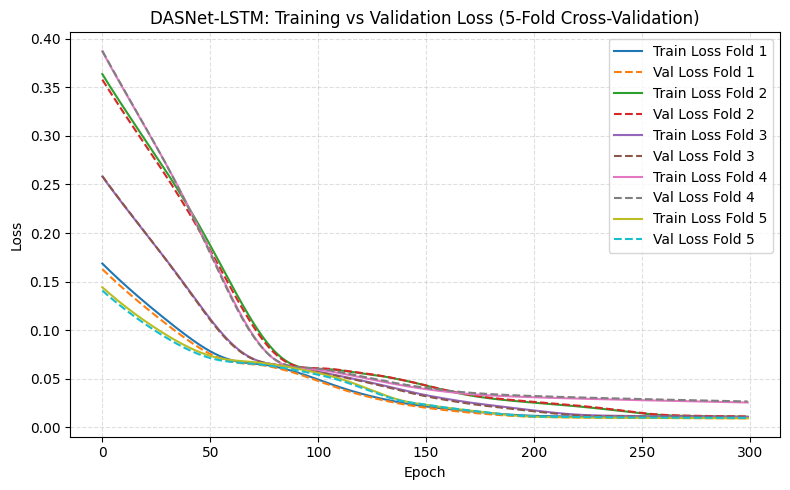

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# GCN layer
# -------------------------
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        # x: [batch, feat], adj: [feat, feat]
        x = torch.matmul(adj, x.T).T
        return torch.relu(self.fc(x))

# -------------------------
# DASNet-LSTM
# -------------------------
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super().__init__()
        # register adj so it follows .to(device)
        self.register_buffer("adj", torch.tensor(adj_matrix, dtype=torch.float32))
        self.gcn  = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc   = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)                 # [batch, hidden_dim]
        attn_weights = torch.softmax(self.attn(x), dim=1)  # [batch, hidden_dim]
        x = x * attn_weights
        x = x.unsqueeze(1)                         # [batch, 1, hidden_dim]
        x, _ = self.lstm(x)                        # [batch, 1, lstm_units]
        out = self.fc(x[:, -1, :])                 # [batch, 1]
        return out.squeeze(-1)                     # [batch]

# -------------------------
# Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim   = X_train.shape[1]
adj_matrix  = np.eye(input_dim)

# 5-Fold Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# Store results for plotting
# -------------------------
all_train_losses = []
all_val_losses = []

# -------------------------
# Cross-Validation Loop
# -------------------------
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")

    # Split data into train and validation for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Convert to Tensors
    X_train_tensor = torch.tensor(X_train_fold.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold.values,  dtype=torch.float32).view(-1).to(device)
    X_val_tensor   = torch.tensor(X_val_fold.values, dtype=torch.float32).to(device)
    y_val_tensor   = torch.tensor(y_val_fold.values,  dtype=torch.float32).view(-1).to(device)

    model = DASNetLSTM(input_dim=input_dim, hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

    # -------------------------
    # Train and Evaluate per Fold
    # -------------------------
    num_epochs = 300
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Append losses for plotting later
        train_losses.append(float(loss.item()))
        val_losses.append(float(val_loss.item()))

        # Calculate metrics for training and validation
        y_pred_train = outputs.detach().cpu().numpy()
        y_true_train = y_train_tensor.detach().cpu().numpy()
        y_pred_val = val_outputs.detach().cpu().numpy()
        y_true_val = y_val_tensor.detach().cpu().numpy()

        # Train Metrics
        mse_train = mean_squared_error(y_true_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        mae_train = mean_absolute_error(y_true_train, y_pred_train)
        r2_train = r2_score(y_true_train, y_pred_train)

        # Validation Metrics
        mse_val = mean_squared_error(y_true_val, y_pred_val)
        rmse_val = np.sqrt(mse_val)
        mae_val = mean_absolute_error(y_true_val, y_pred_val)
        r2_val = r2_score(y_true_val, y_pred_val)

        # Print metrics every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
                  f"MSE Train: {mse_train:.4f} | RMSE Train: {rmse_train:.4f} | "
                  f"MAE Train: {mae_train:.4f} | R2 Train: {r2_train:.4f} | "
                  f"MSE Val: {mse_val:.4f} | RMSE Val: {rmse_val:.4f} | "
                  f"MAE Val: {mae_val:.4f} | R2 Val: {r2_val:.4f}")

    # Append fold losses to all folds' losses
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # -------------------------
    # End of Fold Metrics
    # -------------------------
    print(f"End of Fold {fold + 1}")
    print("=" * 50)

# -------------------------
# Plot Train vs Validation Loss for All Folds
# -------------------------
plt.figure(figsize=(8, 5))

# Plot training and validation losses for each fold
for fold in range(5):
    plt.plot(all_train_losses[fold], label=f"Train Loss Fold {fold + 1}")
    plt.plot(all_val_losses[fold], label=f"Val Loss Fold {fold + 1}", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DASNet-LSTM: Training vs Validation Loss (5-Fold Cross-Validation)")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


**CGN**

Fold 1 - RMSE: 0.0922 | MSE: 0.0085 | MAE: 0.0633 | R2: 0.8856
Fold 2 - RMSE: 0.0947 | MSE: 0.0090 | MAE: 0.0657 | R2: 0.8795
Fold 3 - RMSE: 0.0976 | MSE: 0.0095 | MAE: 0.0695 | R2: 0.8728
Fold 4 - RMSE: 0.0982 | MSE: 0.0096 | MAE: 0.0679 | R2: 0.8706
Fold 5 - RMSE: 0.0966 | MSE: 0.0093 | MAE: 0.0670 | R2: 0.8745

Average RMSE: 0.0958
Average MSE: 0.0092
Average MAE: 0.0667
Average R2: 0.8766


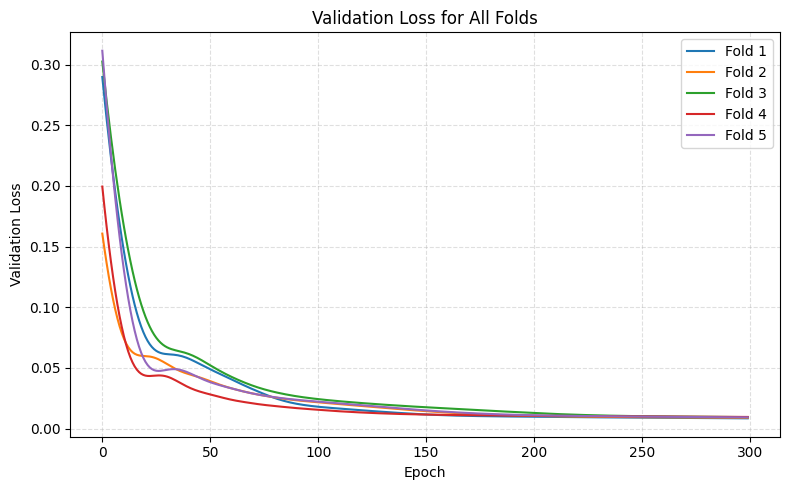

In [ ]:
# Preprocessing data (ensure that 'df' is the DataFrame you're working with)
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)  # Normalize all columns

traffic_scaler = MinMaxScaler()
df['traffic_volume'] = traffic_scaler.fit_transform(df[['traffic_volume']])

# Defining X (input features) and y (target)
X = df.drop(columns=['traffic_volume']).values
y = df['traffic_volume'].values

# Define the GCN Layer and Model
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T
        return torch.relu(self.fc(x))

class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix):
        super().__init__()
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        x = self.fc(x)
        return x

# 5-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Metrics storage
fold_train_losses = []
fold_val_losses = []
fold_rmse = []
fold_mse = []
fold_mae = []
fold_r2 = []

# To store all validation losses for plotting
all_val_losses = []

for train_idx, val_idx in kf.split(X):
    # Split data into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Convert to PyTorch tensors
    X_train_torch, y_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_torch, y_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device)

    # Initialize model, loss, and optimizer
    adj_matrix = np.eye(X_train.shape[1])  # Identity matrix for simplicity
    model = SimpleGCN(input_dim, hidden_dim, output_dim, adj_matrix).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Training loop for each fold
    num_epochs = 300
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_torch)
        loss = criterion(outputs.squeeze(-1), y_train_torch)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_torch)
            val_loss = criterion(val_outputs.squeeze(-1), y_val_torch)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    # Store validation loss for this fold
    all_val_losses.append(val_losses)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_torch).detach().cpu().numpy()
        y_true = y_val_torch.detach().cpu().numpy()

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        fold_rmse.append(rmse)
        fold_mse.append(mse)
        fold_mae.append(mae)
        fold_r2.append(r2)

    # Store train and validation losses for each fold
    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])

    print(f"Fold {fold} - RMSE: {rmse:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    fold += 1

# Calculate the average metrics across all folds
avg_rmse = np.mean(fold_rmse)
avg_mse = np.mean(fold_mse)
avg_mae = np.mean(fold_mae)
avg_r2 = np.mean(fold_r2)

print(f"\nAverage RMSE: {avg_rmse:.4f}")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average R2: {avg_r2:.4f}")

# Plot validation loss curve for all folds
plt.figure(figsize=(8, 5))
for i, val_losses in enumerate(all_val_losses):
    plt.plot(val_losses, label=f'Fold {i+1}')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for All Folds")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
